In [1]:
import dht11 as DHT
import arrow
import st7735_custom
import pandas as pd
from IPython.display import display
from IPython.display import clear_output
from time import sleep
import digitalio
import board
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
from PIL import Image
from threading import Thread
import RPi.GPIO as GPIO
from time import sleep

GPIO.setmode(GPIO.BCM)
GPIO.setwarnings(False)

# DHT LCD
lcd = st7735_custom.ST7735( cs_pin = digitalio.DigitalInOut(board.CE0),
                            dc_pin = digitalio.DigitalInOut(board.D25),
                            reset_pin = digitalio.DigitalInOut(board.D24))

dht = DHT.DHT11(pin = 2)

pir_results = pd.DataFrame([],columns=["motion", "time"])
pir_plot = pir_results.copy()

dht_results = pd.DataFrame([],columns=["temperature", "humidity", "time"])
dht_plot = dht_results.copy()

plotdf = pd.concat([dht_plot, pir_plot], ignore_index=True)
plotdf['count'] = plotdf.groupby(['time'])['motion'].transform('count')

In [2]:
def dhtToLcd():
    global dht_results
    global dht_plot
    while(True):
        result = dht.read()

        if result.is_valid():
            clear_output(wait=False)
            dht_results.loc[len(dht_results.index)] = [result.temperature, result.humidity, arrow.now(tz="+08:00").format()]
            
            dht_plot = dht_results.copy()
            dht_plot.time = dht_plot.time.apply(lambda x: arrow.get(x).format('YYYY-MM-DD HH:mm'))
            print(f"Temp: {dht_results.loc[len(dht_results.index)-1, 'temperature']} \n Hum: {dht_results.loc[len(dht_results.index)-1, 'humidity']}")
            # display(dht_results)
            plotdf = pd.concat([dht_plot, pir_plot], ignore_index=True)
            plot = plt.show()
            display(plotdf)
            # plt.figure().set_figheight(7)
            # sns.lineplot(x="time", y="temperature", data=dht_plot)
            # sns.lineplot(x="time", y="humidity", data=dht_plot)
            # plt.yticks(np.arange(0, 101, 2))
            
            # __tmpfile = BytesIO()
            # plt.savefig("dht_plot.jpg", format='jpg')

            # plot = plt.show()

            # # lcd.custom_rectangle(color1=st7735_custom.BLACK, color2=st7735_custom.WHITE)
            # # lcd.__image = Image.open(__tmpfile).rotate(0).resize((lcd.width, lcd.height))
            # lcd.custom_img("dht_plot.jpg")
            # lcd.custom_text(text=f"Temp: {dht_results.loc[len(dht_results.index)-1, 'temperature']} \n Hum: {dht_results.loc[len(dht_results.index)-1, 'humidity']}", color=st7735_custom.RED)
            # lcd.image()

dhtThread = Thread(target=dhtToLcd)

In [3]:
pir = 15
GPIO.setup(pir, GPIO.IN)
moved = 0
sleep(2)      #give sensor to startup

pir_results = pd.DataFrame([],columns=["motion", "time"])
pir_plot = pir_results.copy()

def pirDetected():
    global pir_results
    global pir_plot
    try:
        while True:
            moved = GPIO.input(pir)
            if moved == 1:
                clear_output(wait=False)
                pir_results.loc[len(pir_results.index)] = [True, arrow.now(tz="+08:00").format()]
                print("Motion detected!")
                pir_plot = pir_results.copy()
                pir_plot.time = pir_plot.time.apply(lambda x: arrow.get(x).format('YYYY-MM-DD HH:mm'))
                print(f"Motion: {pir_results.loc[len(pir_results.index)-1, 'time']}")
                # display(pir_results)
                plotdf = pd.concat([dht_plot, pir_plot], ignore_index=True)
                plot = plt.show()
                display(plotdf)
                # plt.figure().set_figheight(7)
                # sns.lineplot(x="time", y="temperature", data=pir_plot)
                # sns.lineplot(x="time", y="humidity", data=pir_plot)
                # plt.yticks(np.arange(0, 101, 2))
                
                # __tmpfile = BytesIO()
                # plt.savefig("pir_plot.jpg", format='jpg')

                # plot = plt.show()

                # # lcd.custom_rectangle(color1=st7735_custom.BLACK, color2=st7735_custom.WHITE)
                # # lcd.__image = Image.open(__tmpfile).rotate(0).resize((lcd.width, lcd.height))
                # lcd.custom_img("plot.jpg")
                # lcd.custom_text(text=f"Temp: {dht_results.loc[len(dht_results.index)-1, 'temperature']} \n Hum: {dht_results.loc[len(dht_results.index)-1, 'humidity']}", color=st7735_custom.RED)
                # lcd.image()
            sleep(0.2)

    finally:
        print("Exit the program...")
        GPIO.cleanup()
        
pirThread = Thread(target=pirDetected)
pirThread.setDaemon(True)

/tmp/ipykernel_16444/2251487482.py:48: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  pirThread.setDaemon(True)


In [4]:
pirThread.start()

Motion detected!
Motion: 2024-05-01 22:51:22+08:00
Motion detected!
Motion: 2024-05-01 22:53:03+08:00
Motion detected!
Motion: 2024-05-01 22:53:17+08:00
Motion detected!
Motion: 2024-05-01 22:54:54+08:00
Motion detected!
Motion: 2024-05-01 22:55:22+08:00
Motion detected!
Motion: 2024-05-01 22:55:28+08:00
Motion detected!
Motion: 2024-05-01 22:55:49+08:00
Motion detected!
Motion: 2024-05-01 22:55:56+08:00


In [5]:
dhtThread.start()

In [6]:
# plt.figure().set_figheight(7)
# sns.lineplot(x="time", y="count", data=plotdf)
# sns.lineplot(x="time", y="temperature", data=plotdf)
# sns.lineplot(x="time", y="humidity", data=plotdf)
# plt.yticks(np.arange(0, 101, 2))

def draw_graph():
    while True:
        plotdf = pd.concat([dht_plot, pir_plot], ignore_index=True)
        plotdf['count'] = plotdf.groupby(['time'])['motion'].transform('count')
        plotdf.drop_duplicates(subset=['time', 'motion'], keep='last', inplace=True)
        plotdf.reset_index(drop=True, inplace=True)
        plt.figure().set_figheight(7)
        sns.lineplot(x="time", y="count", data=plotdf)
        sns.lineplot(x="time", y="temperature", data=plotdf)
        sns.lineplot(x="time", y="humidity", data=plotdf)
        plt.yticks(np.arange(0, 101, 2))
        plot = plt.show()
        # # __tmpfile = BytesIO()
        # plt.savefig("plot.jpg", format='jpg')
        # # display(plotdf)
        # # plot = plt.show()
        # # lcd.__image = Image.open(__tmpfile).rotate(0).resize((lcd.width, lcd.height))
        # lcd.custom_img("plot.jpg")
        # # lcd.custom_text(text=f"Temp: {dht_results.loc[len(dht_results.index)-1, 'temperature']} \n Hum: {dht_results.loc[len(dht_results.index)-1, 'humidity']} \n Last Motion Time: {pir_results.loc[len(pir_results.index)-1, 'time']}", color=st7735_custom.RED)
        # lcd.image()

drawThread = Thread(target=draw_graph)
drawThread.setDaemon(True)

/tmp/ipykernel_16444/2635389682.py:29: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  drawThread.setDaemon(True)


In [7]:
drawThread.start()

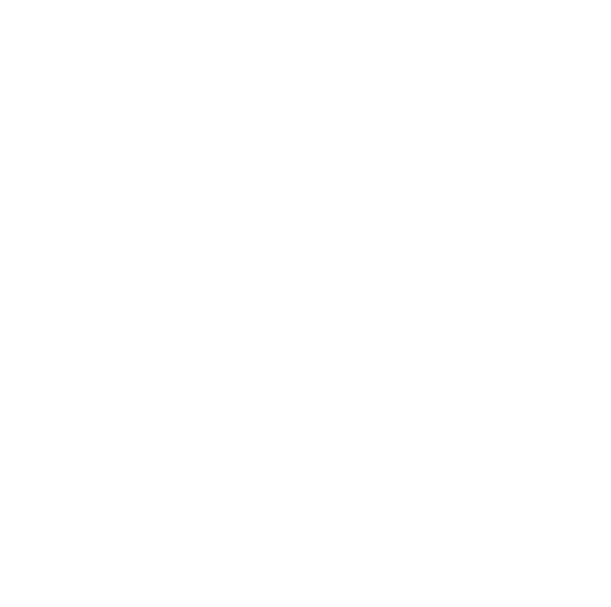

,temperature,humidity,time,motion
0,NaN,NaN,2024-05-01 22:51,True
1,NaN,NaN,2024-05-01 22:53,True
2,NaN,NaN,2024-05-01 22:53,True
3,NaN,NaN,2024-05-01 22:54,True
4,NaN,NaN,2024-05-01 22:55,True
5,NaN,NaN,2024-05-01 22:55,True
6,NaN,NaN,2024-05-01 22:55,True
7,NaN,NaN,2024-05-01 22:55,True


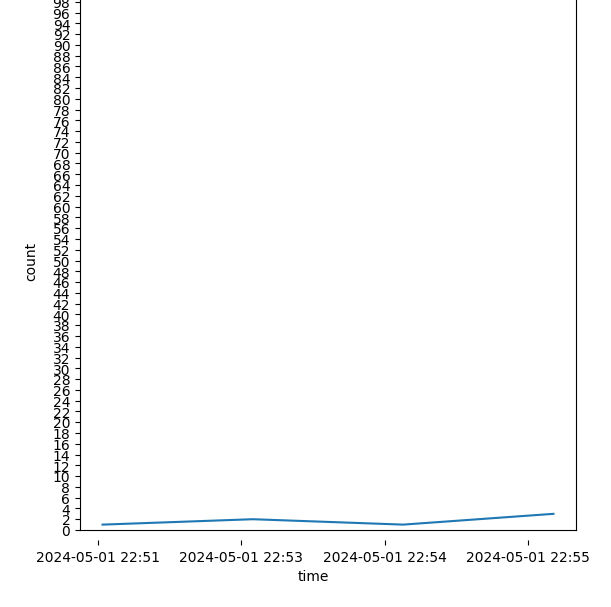

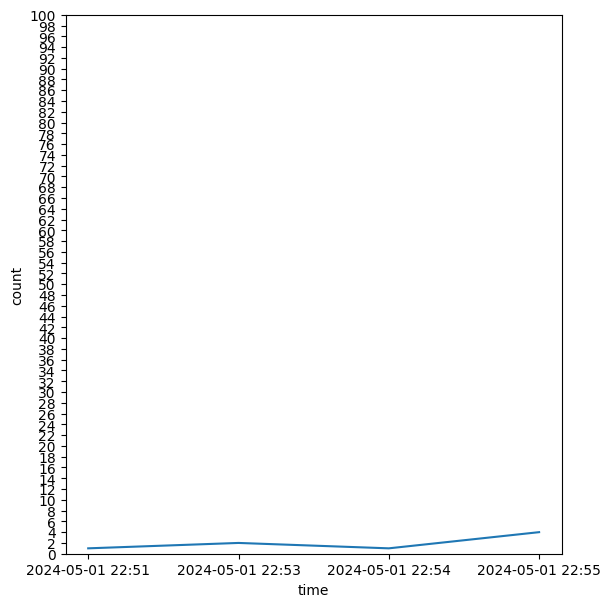

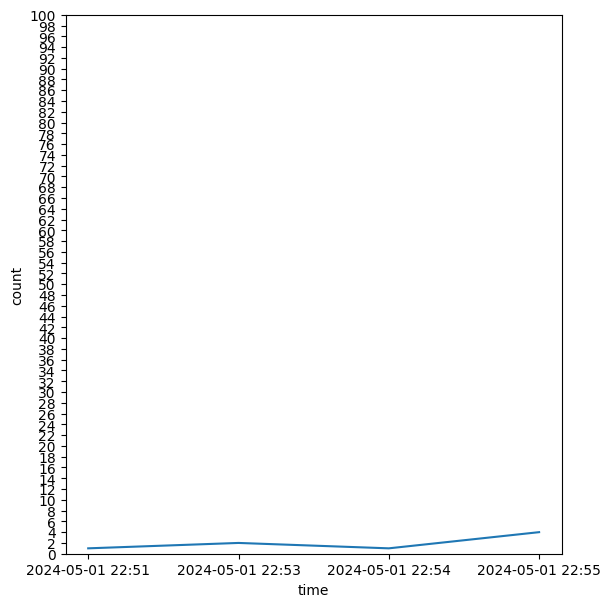

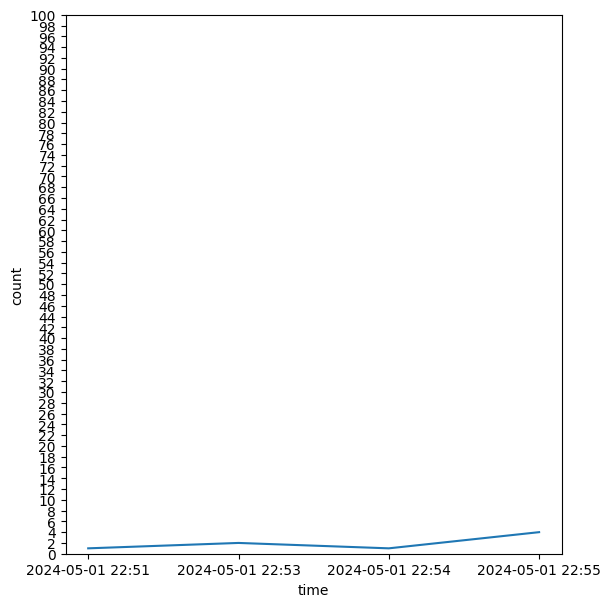

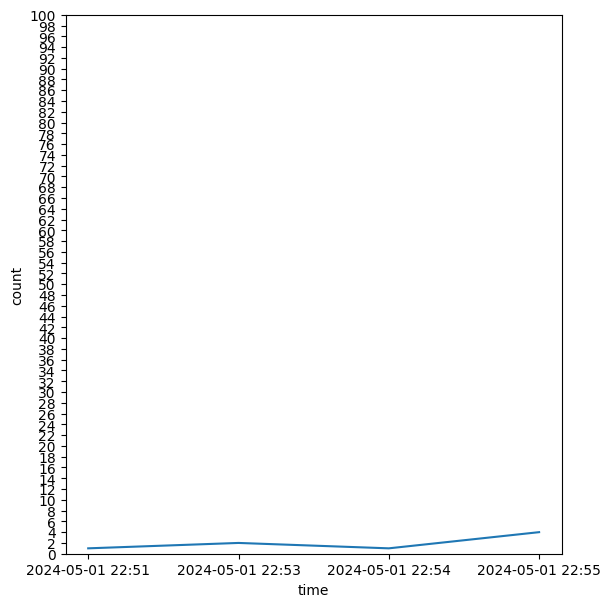

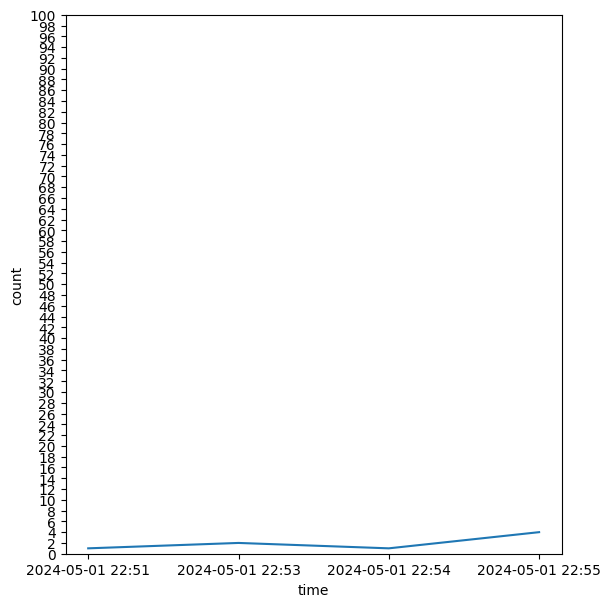

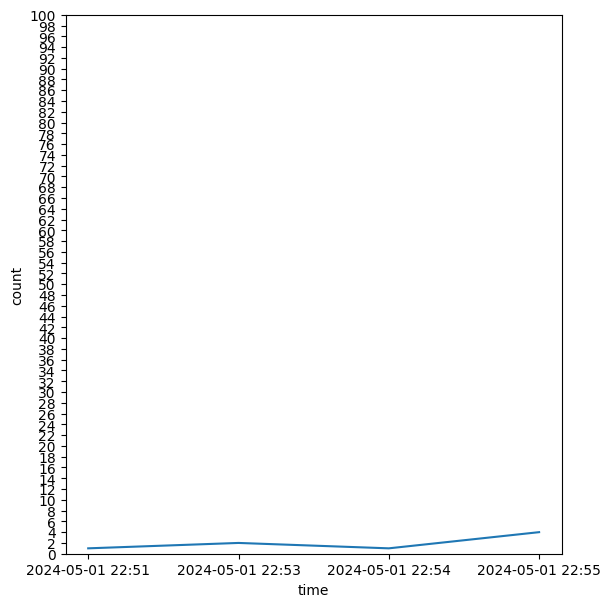

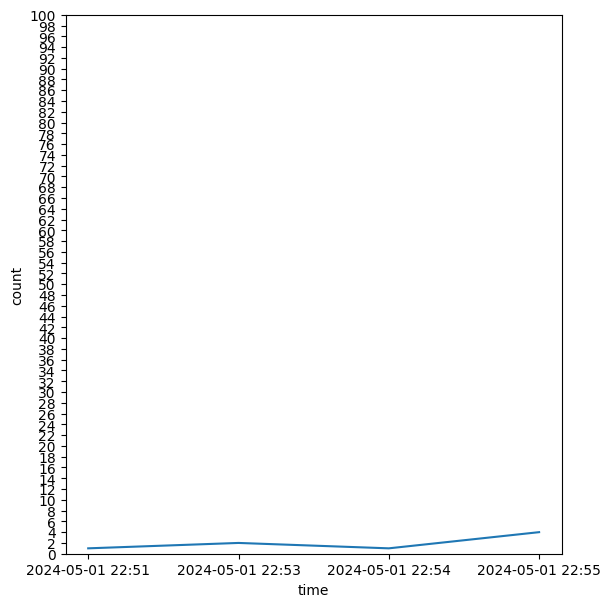

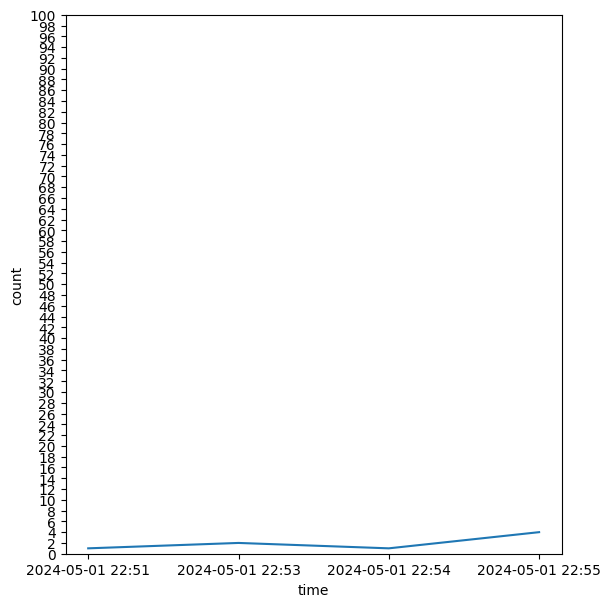

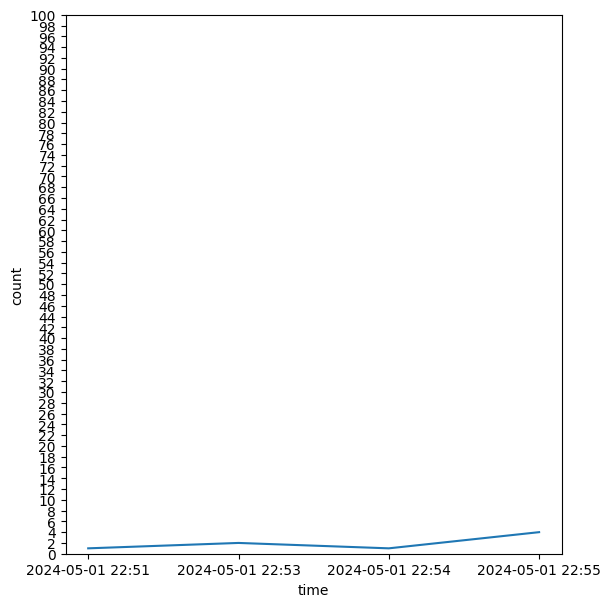

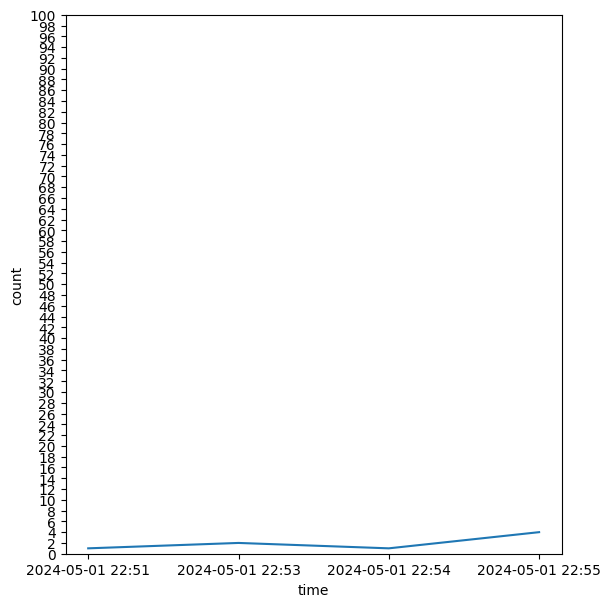

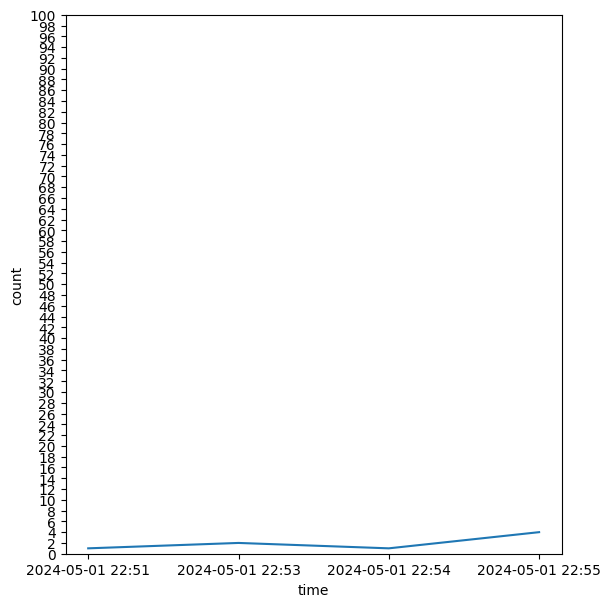

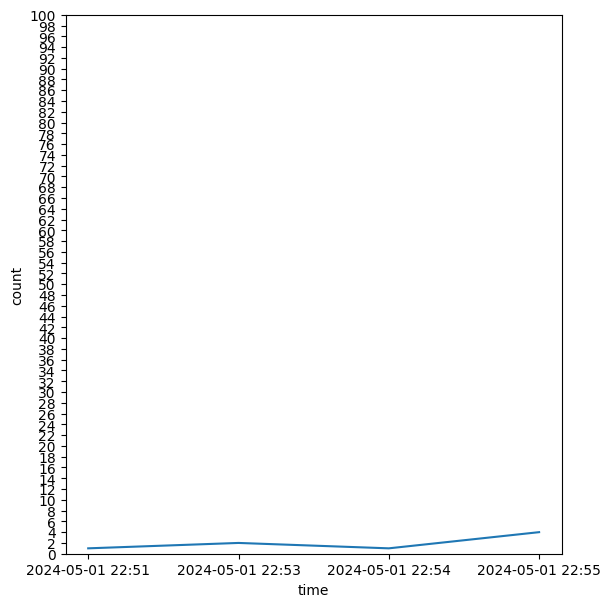

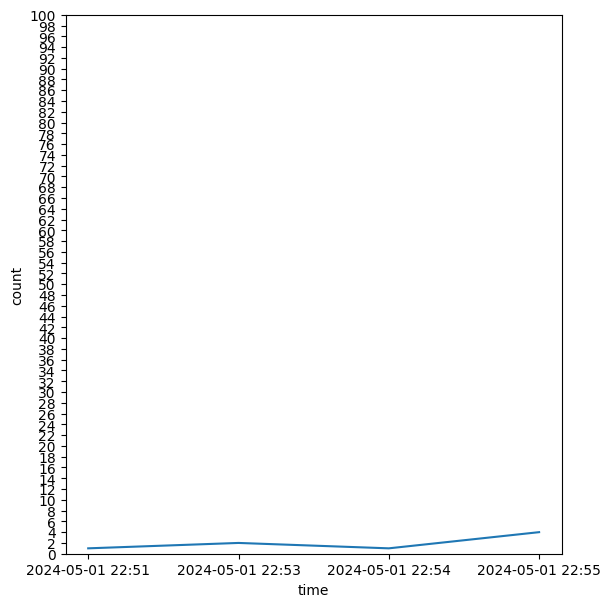

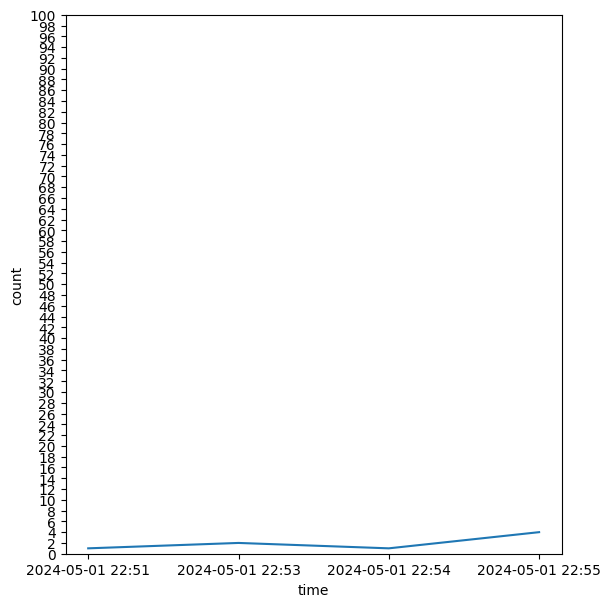

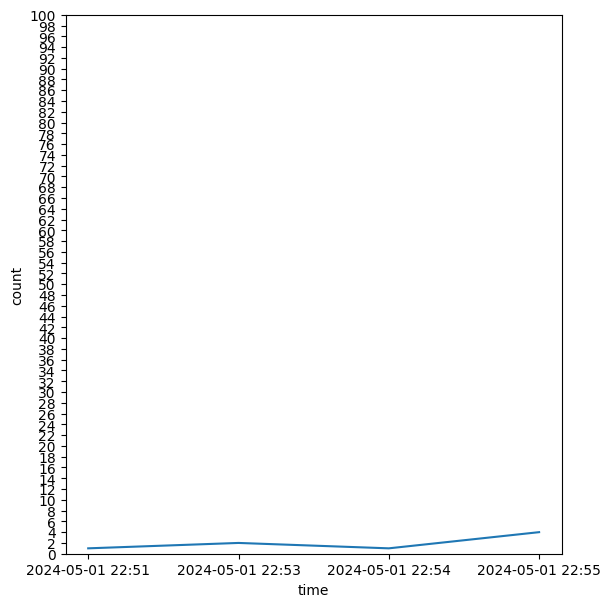

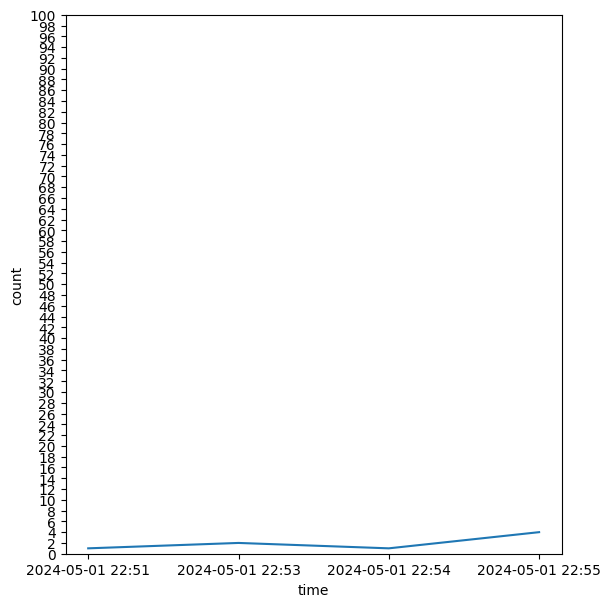

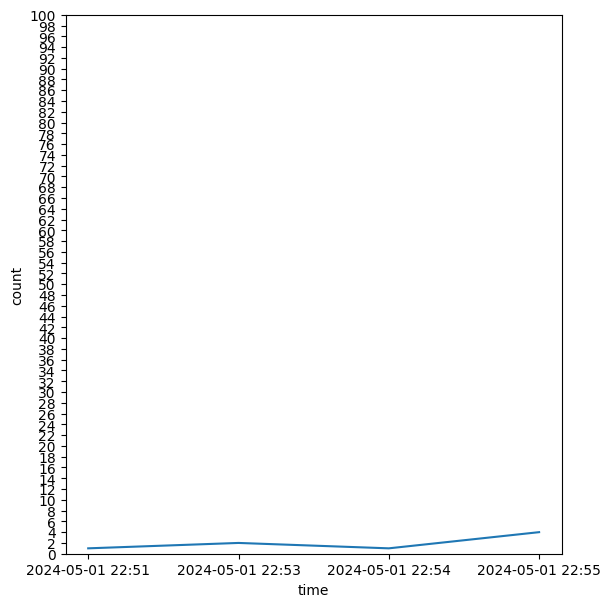

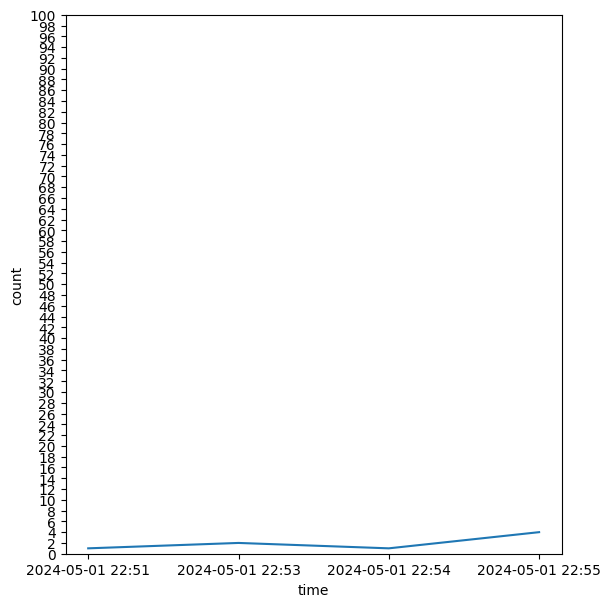

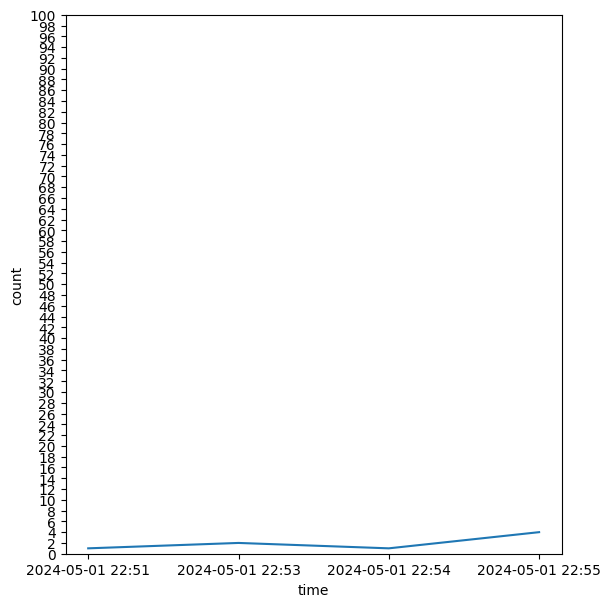

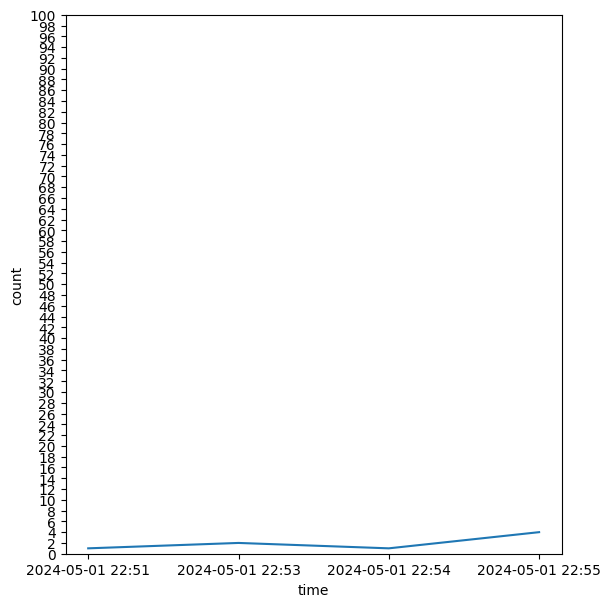

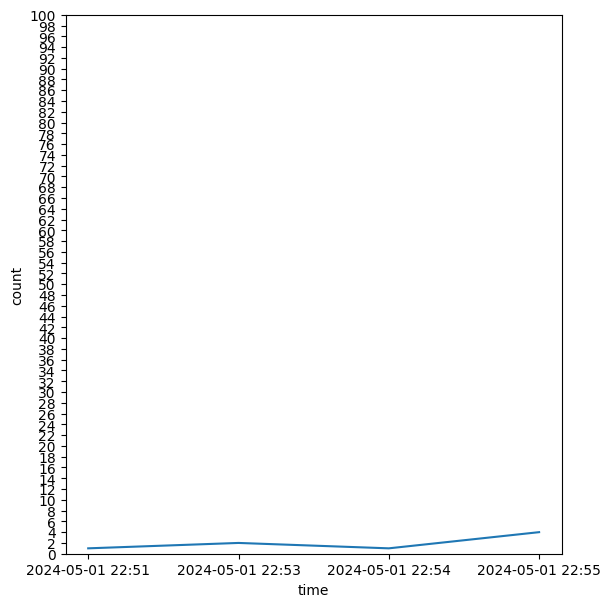

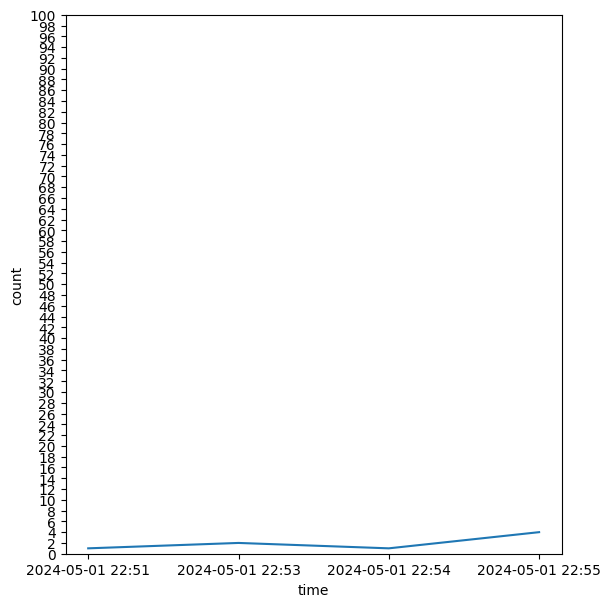

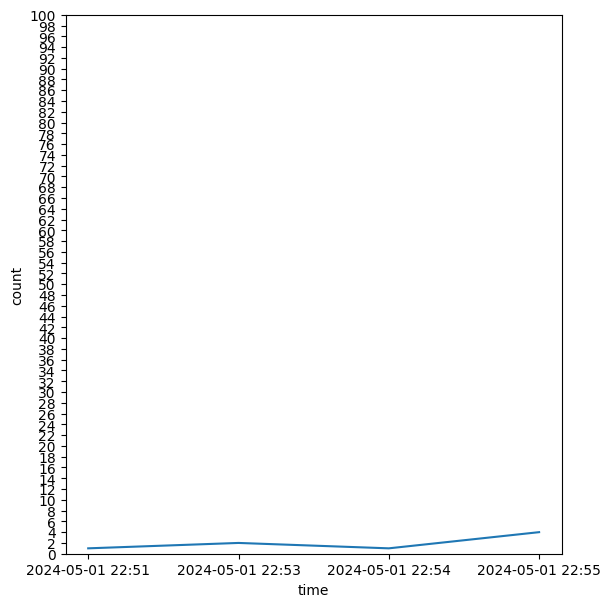

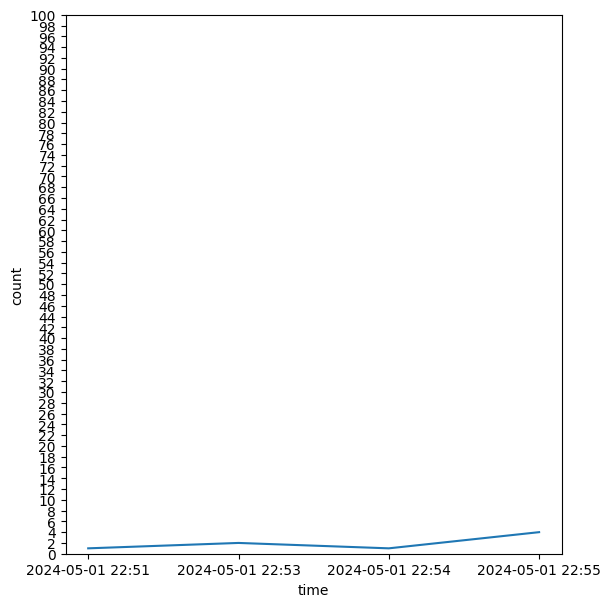

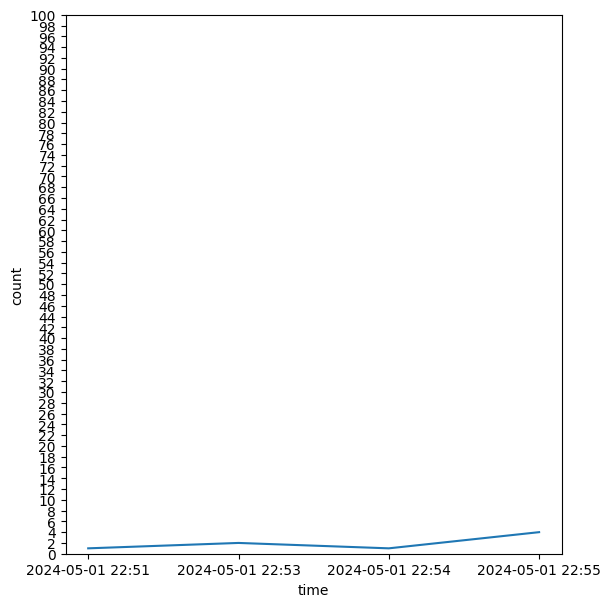

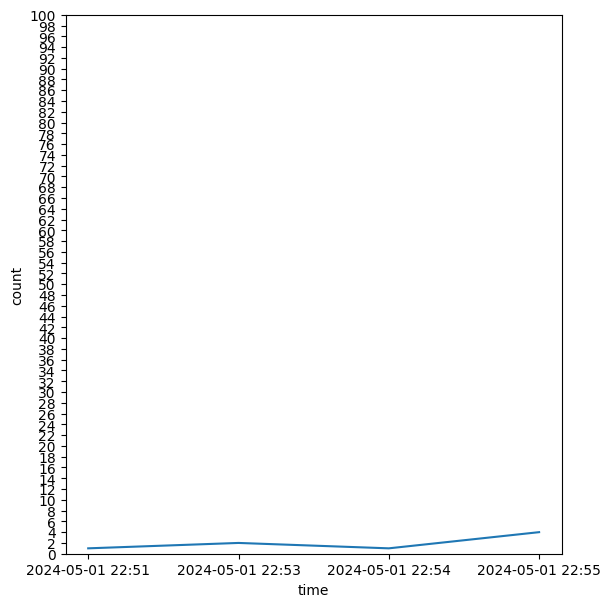

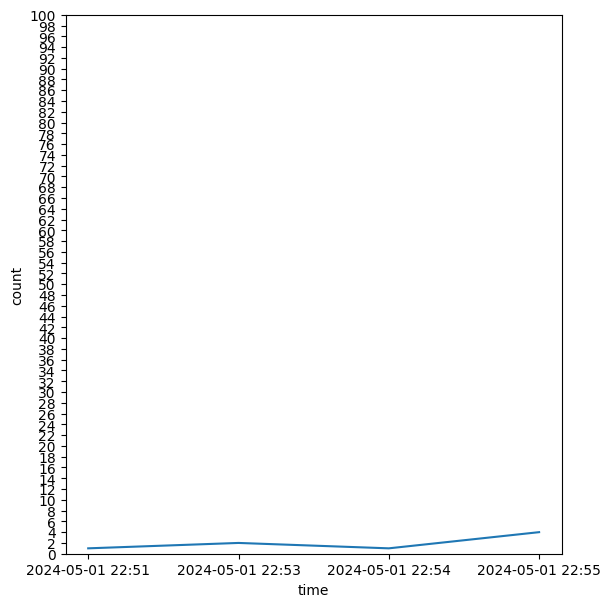

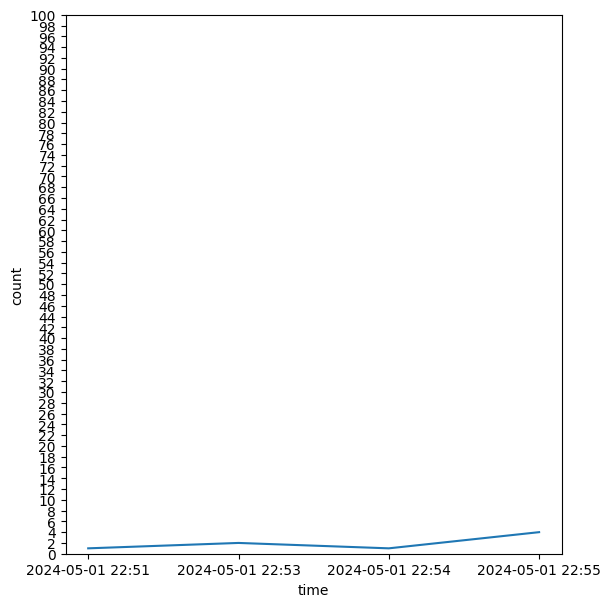

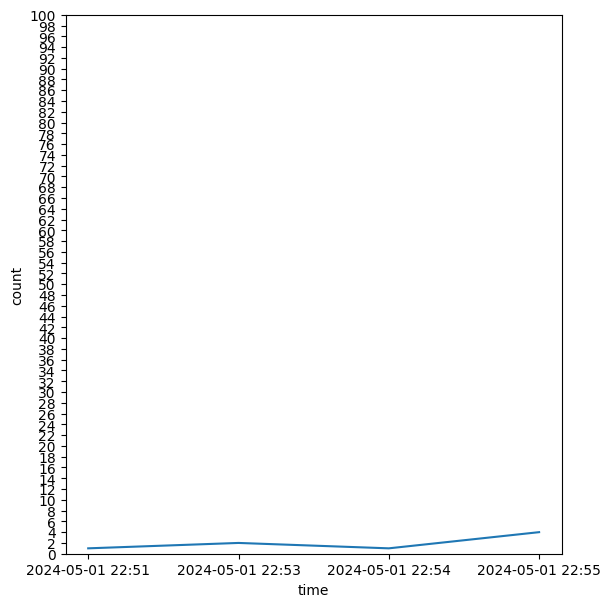

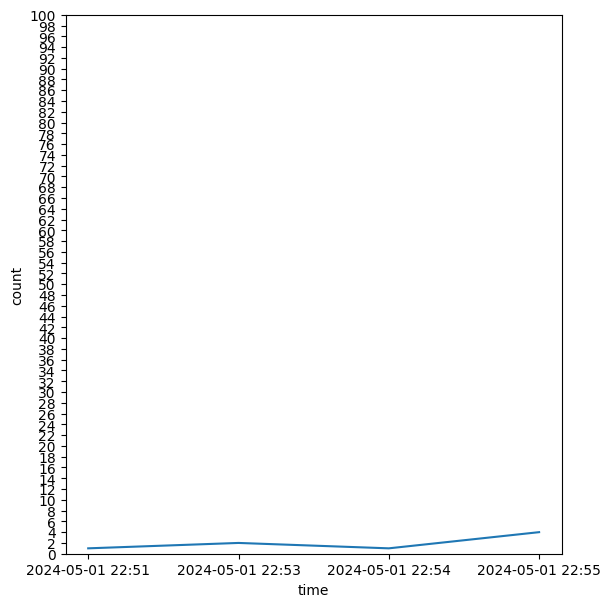

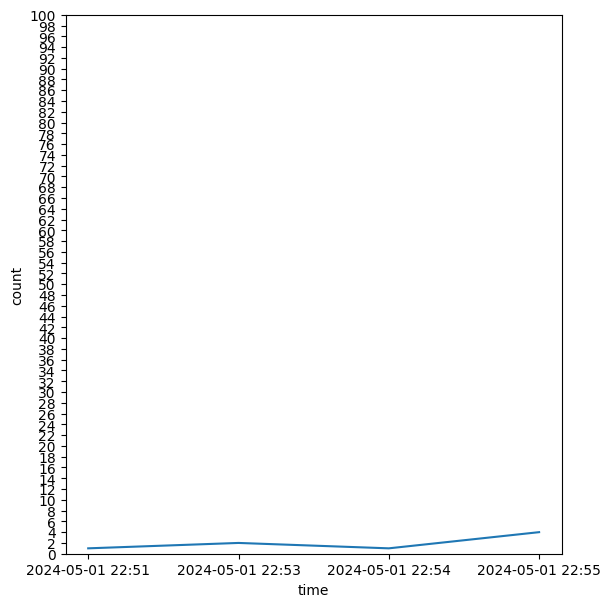

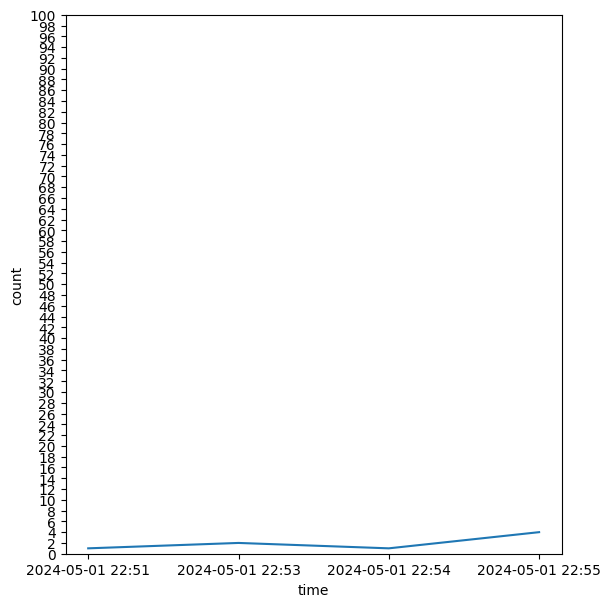

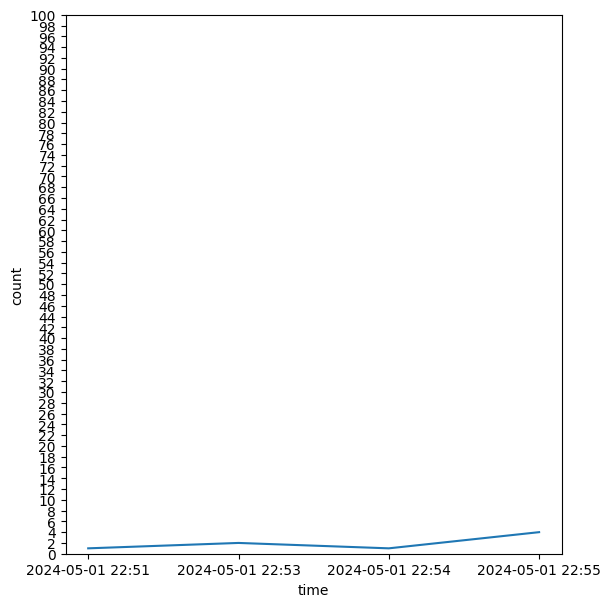

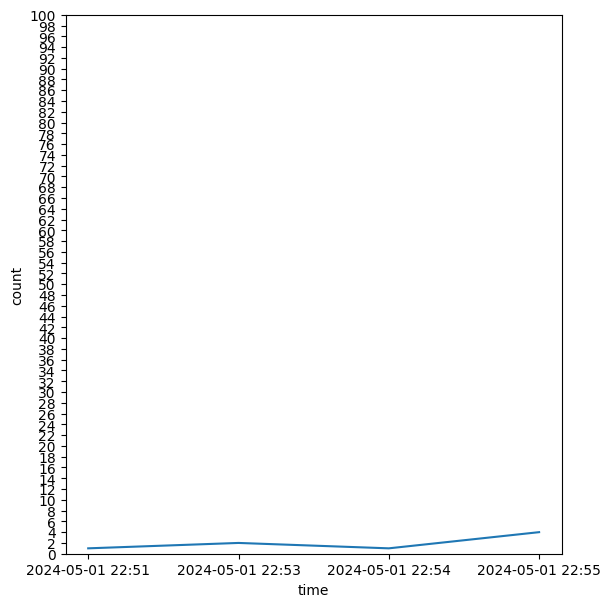

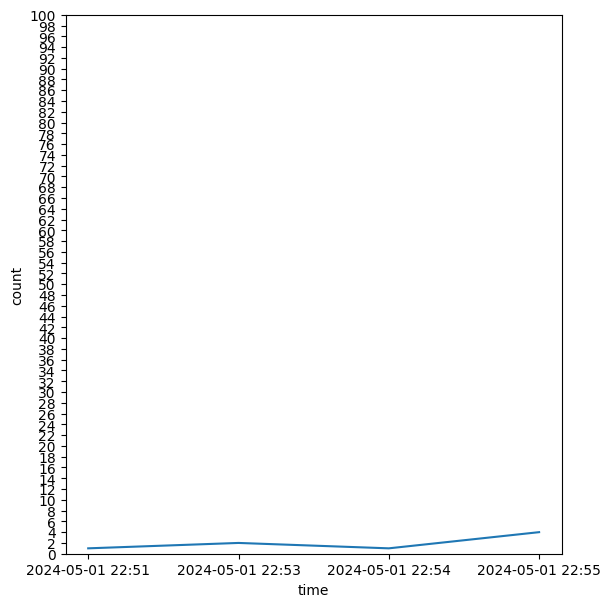

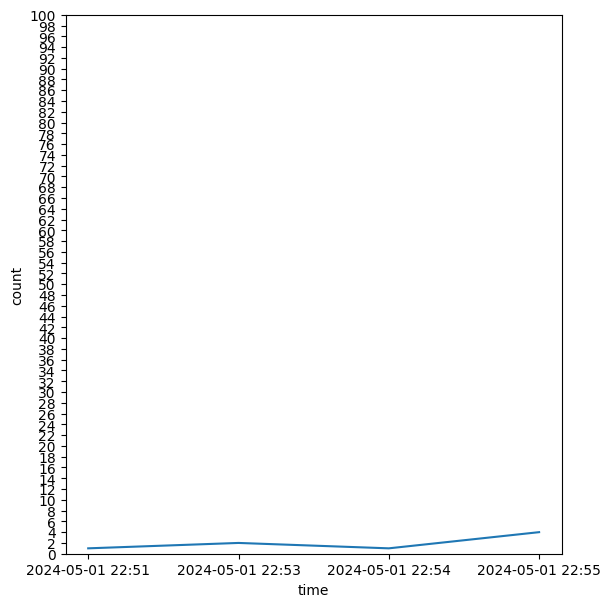

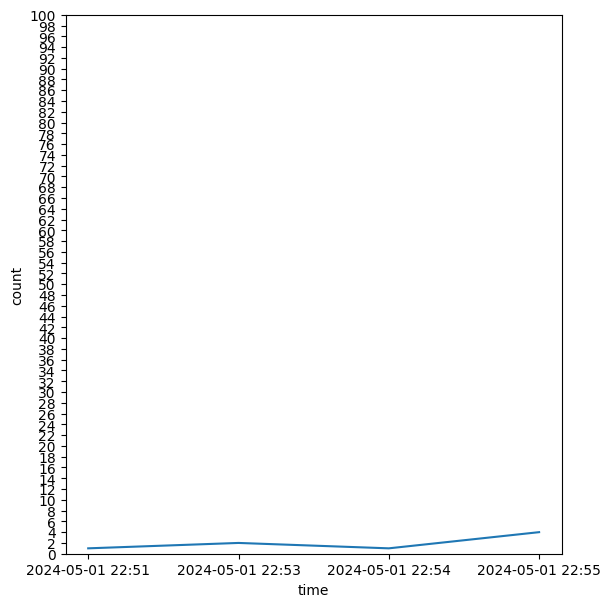

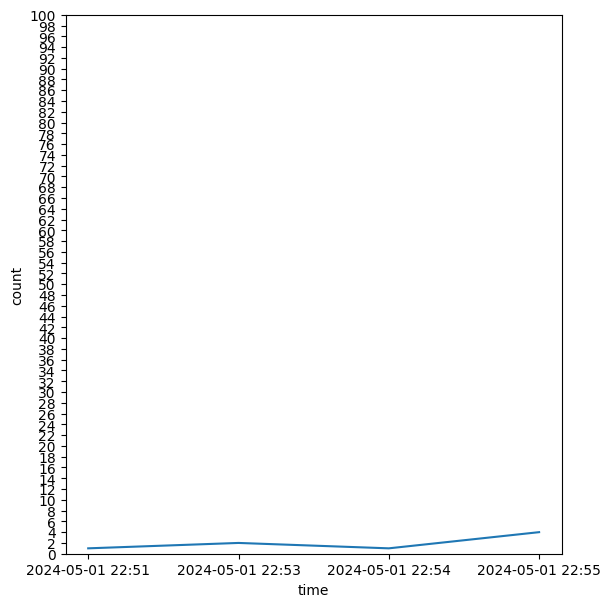

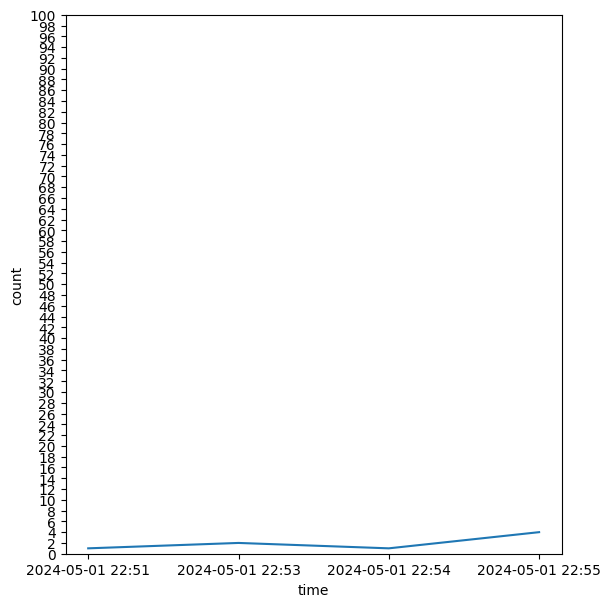

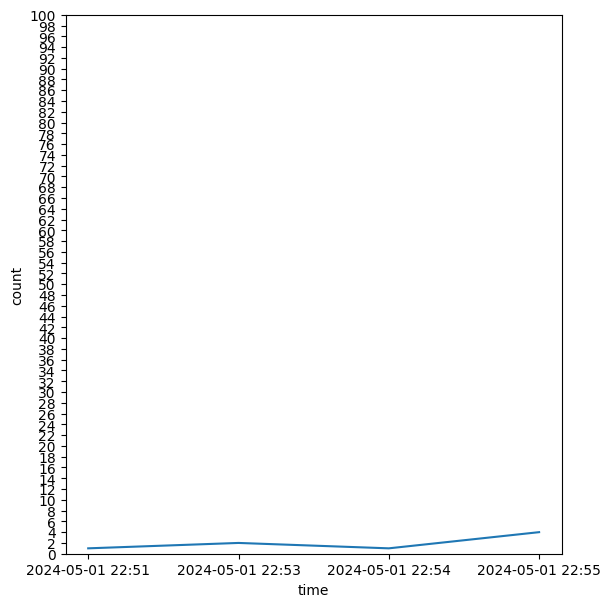

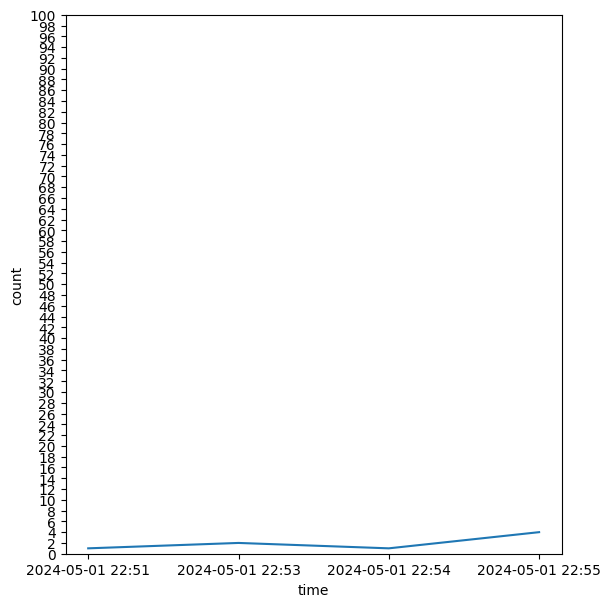

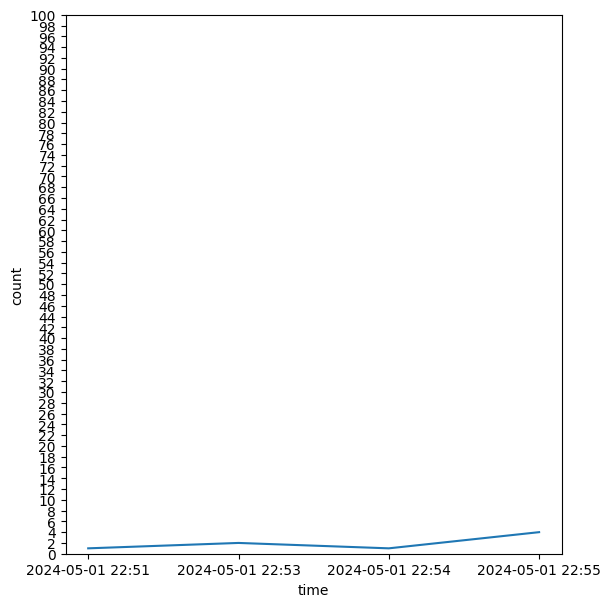

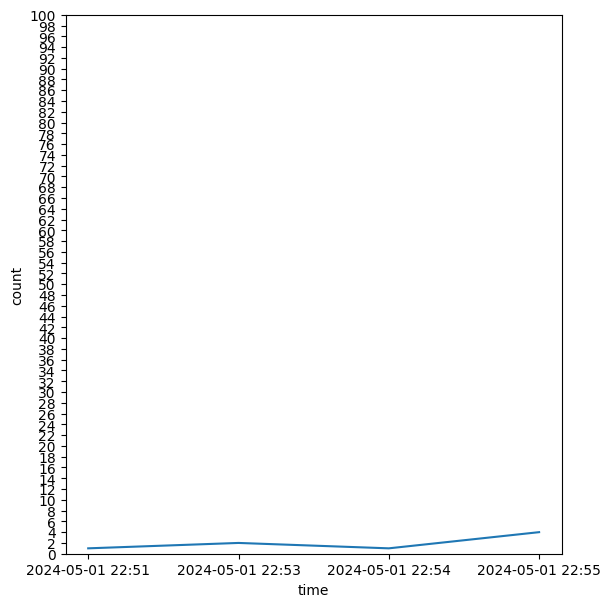

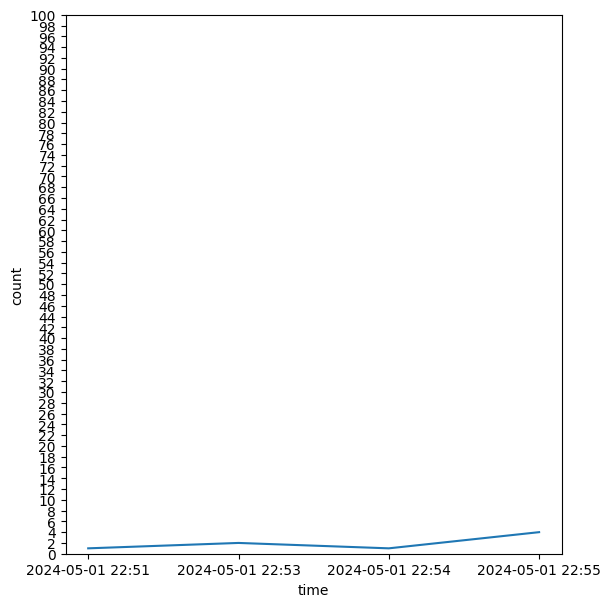

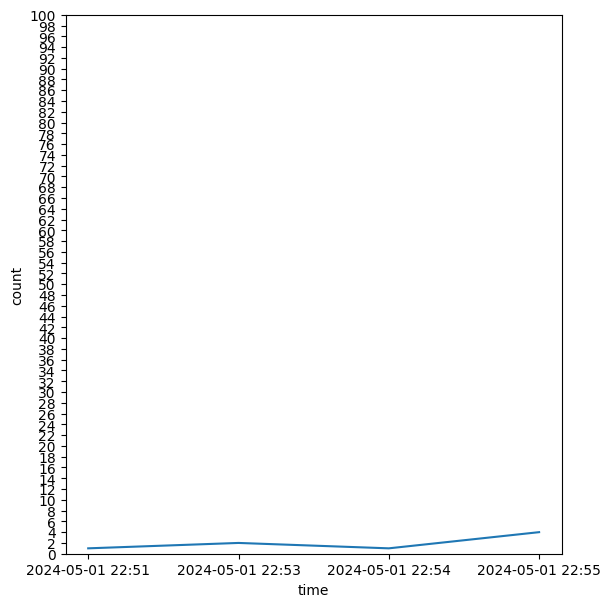

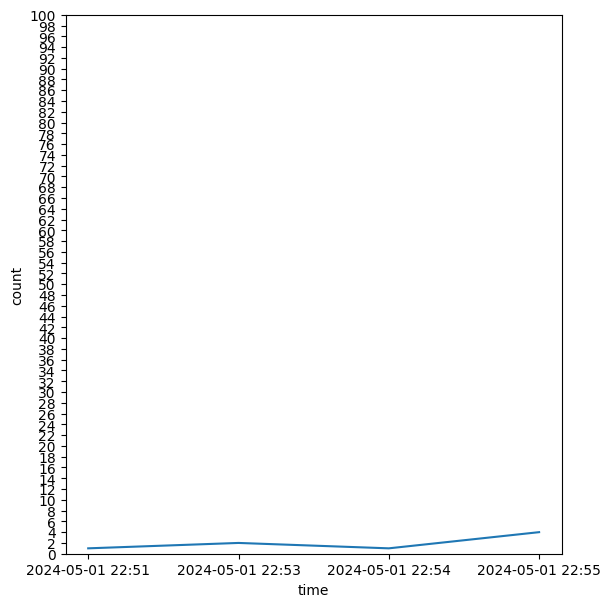

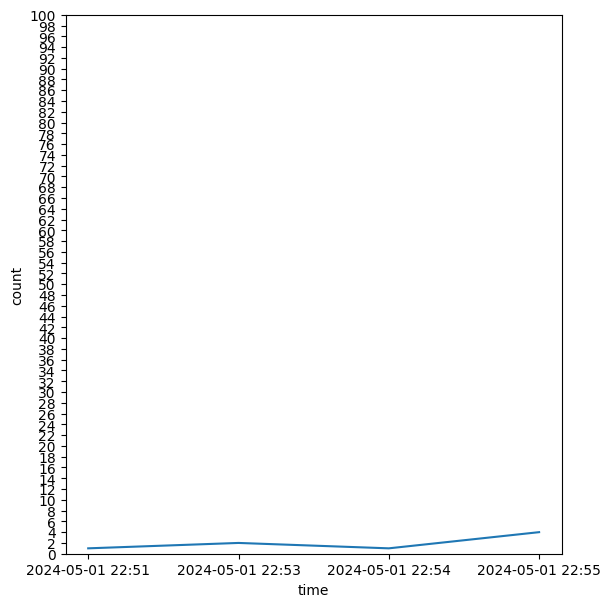

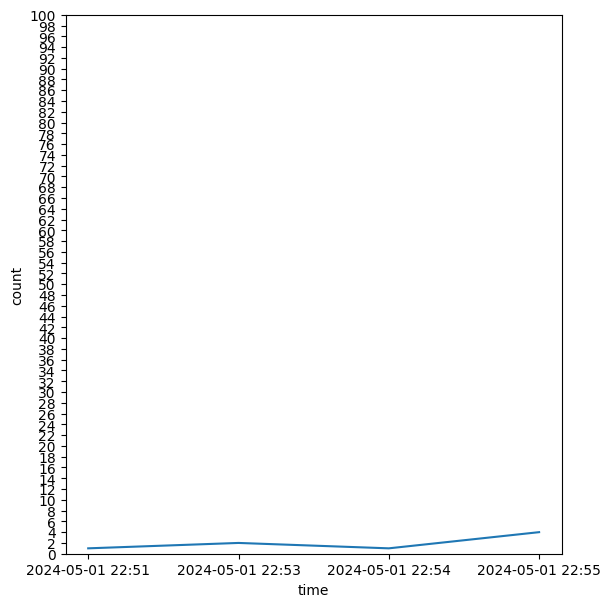

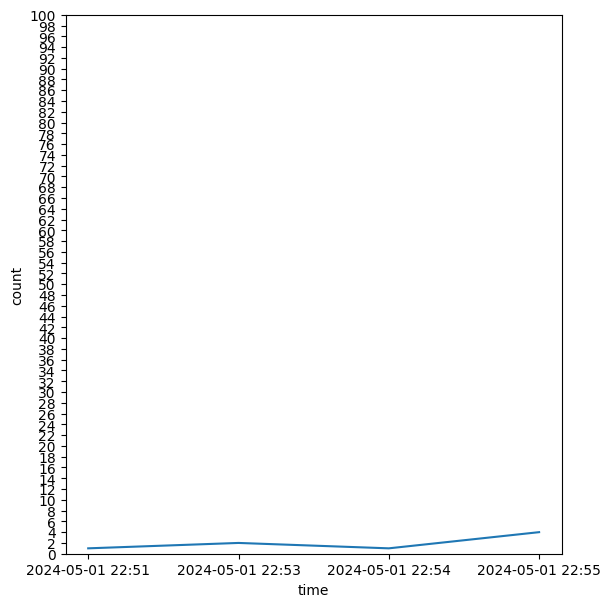

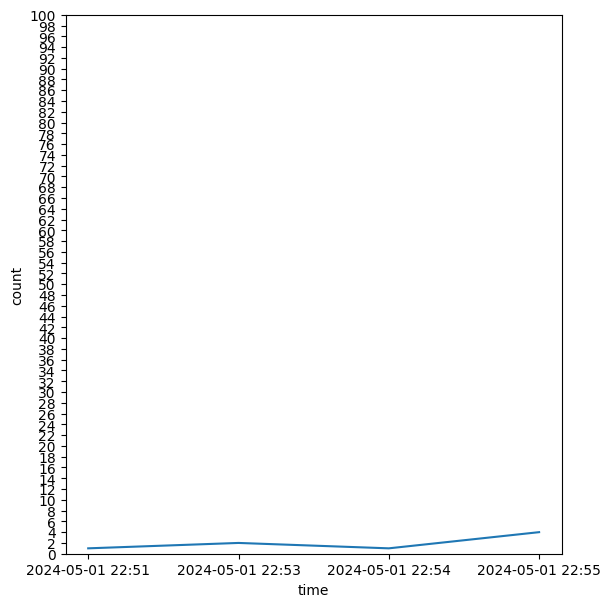

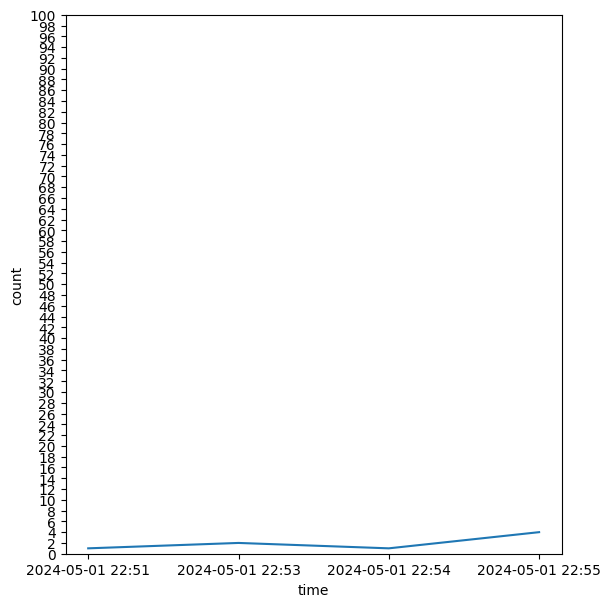

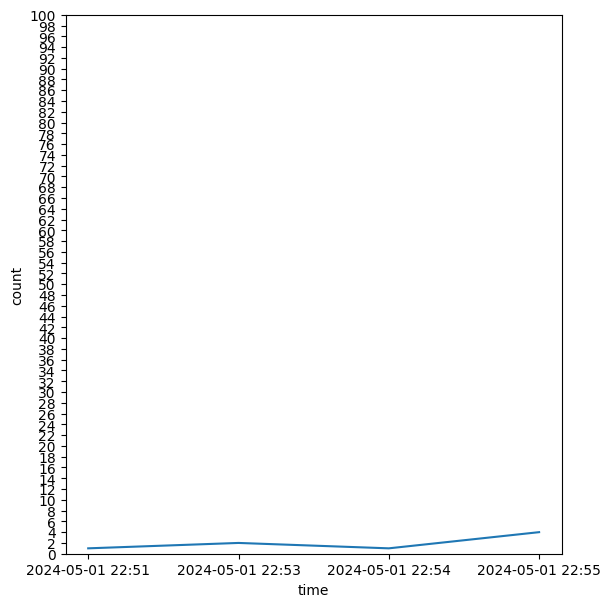

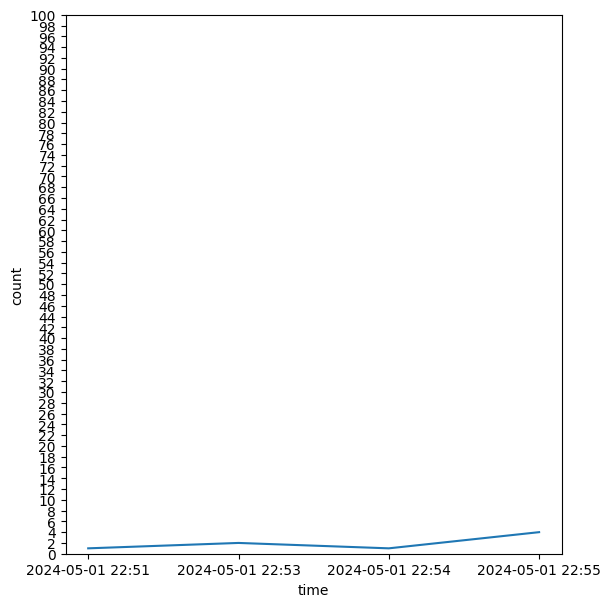

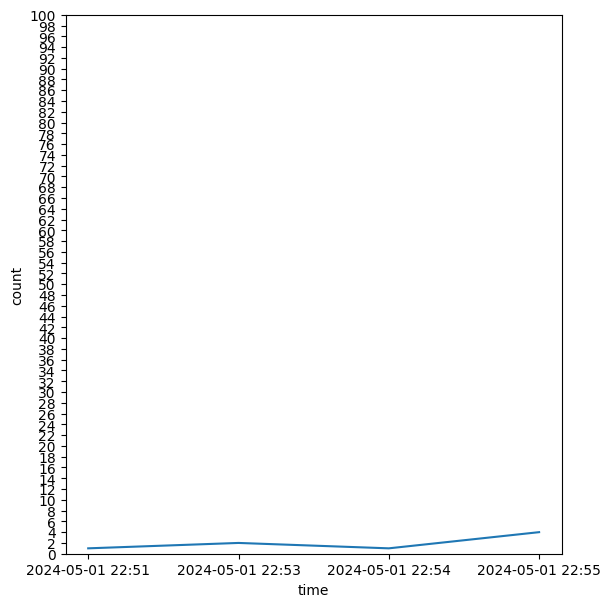

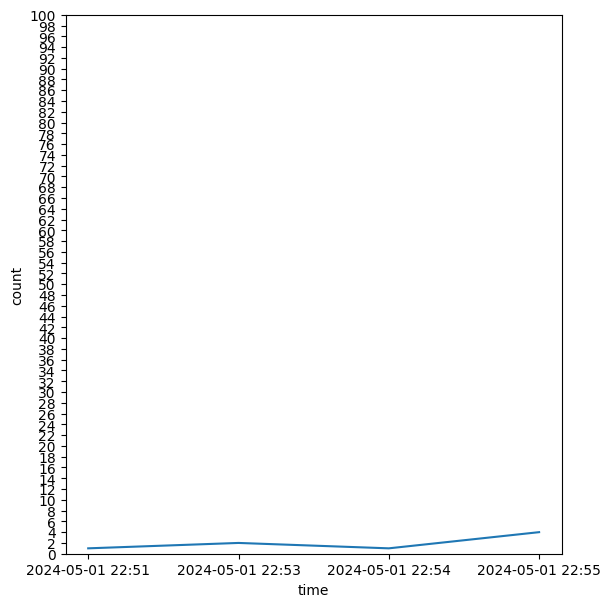

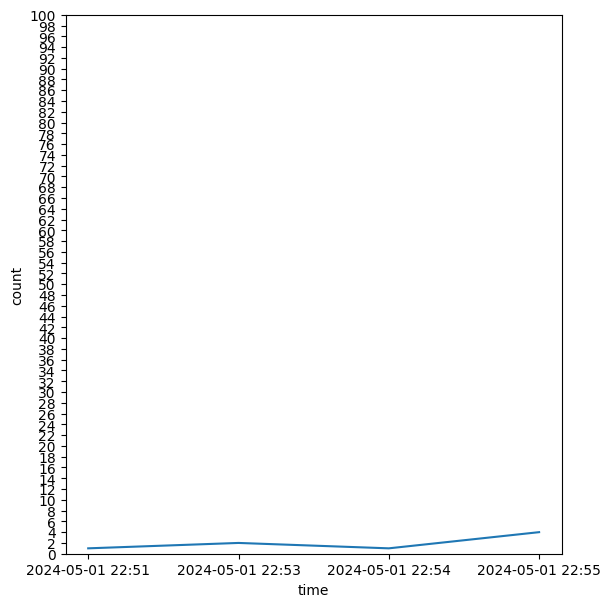

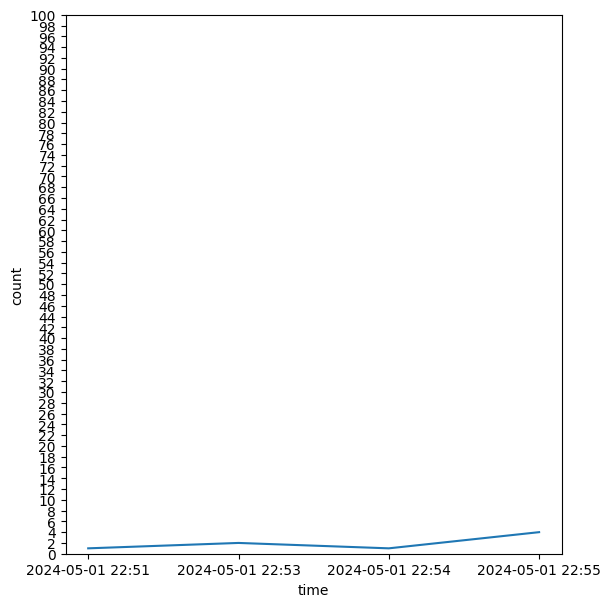

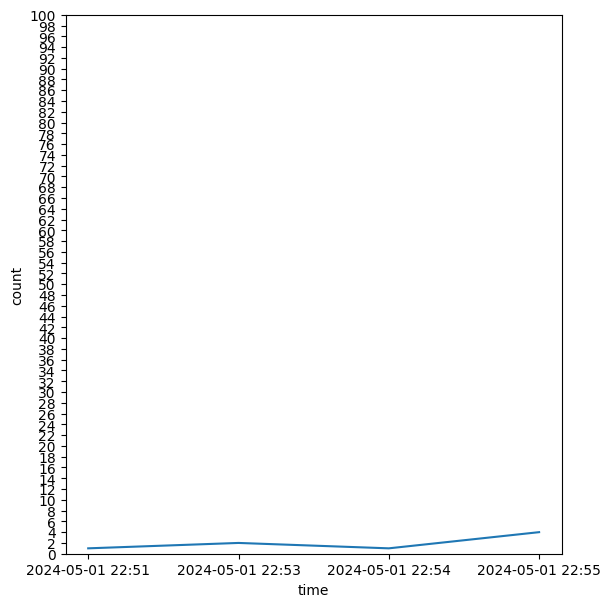

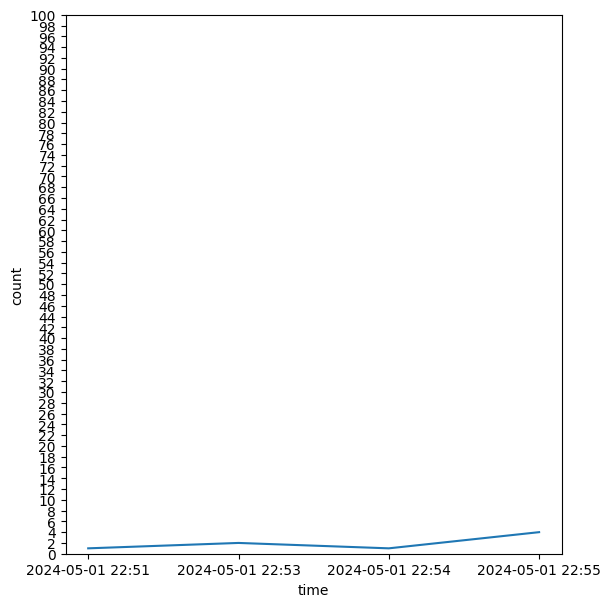

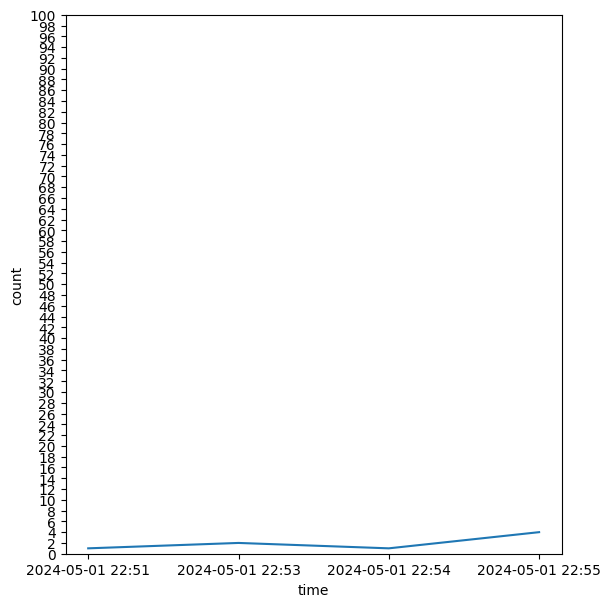

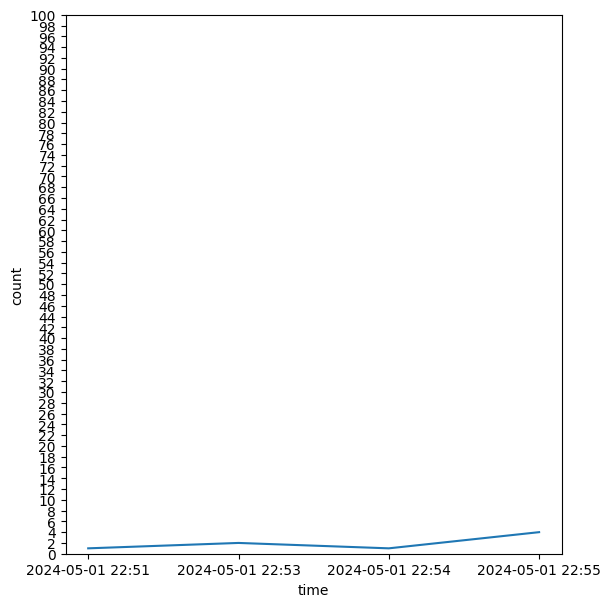

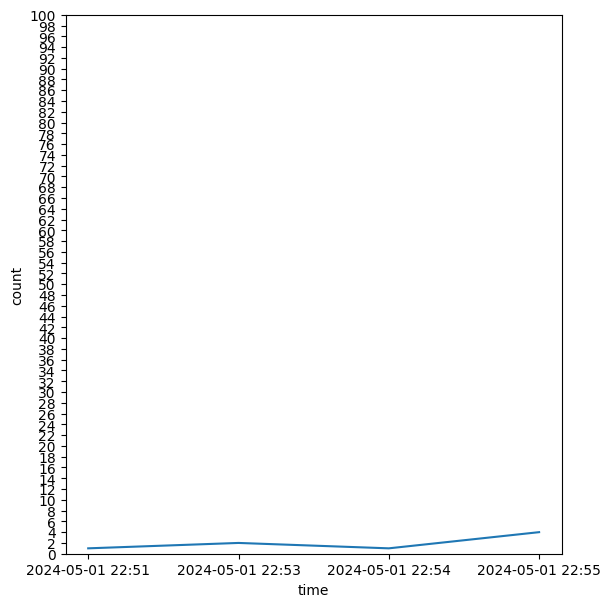

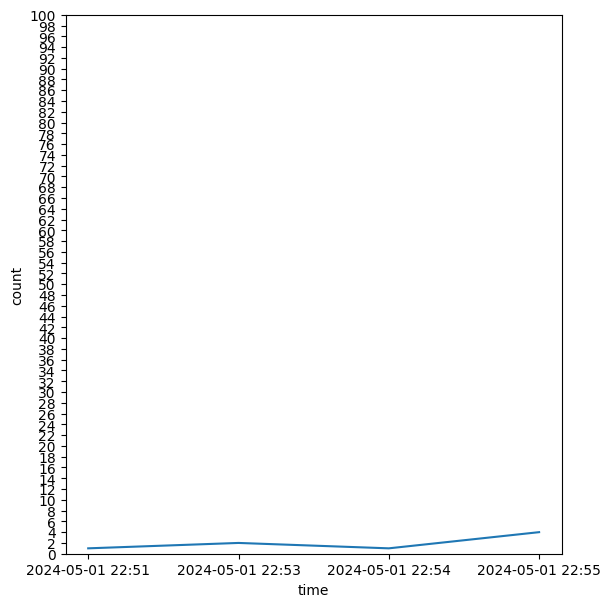

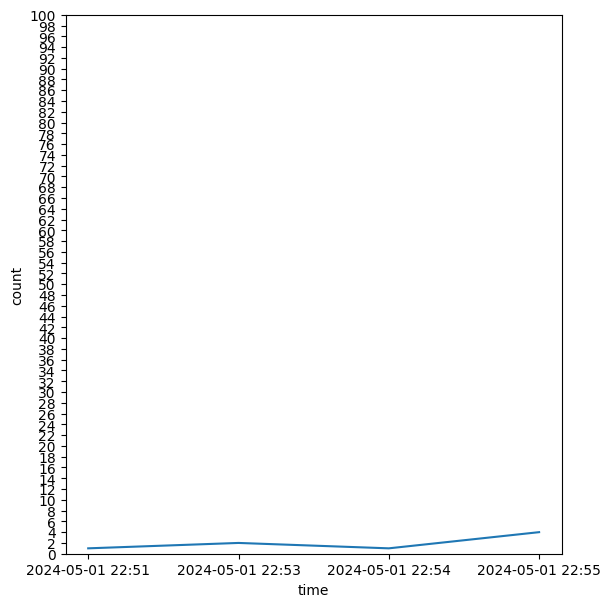

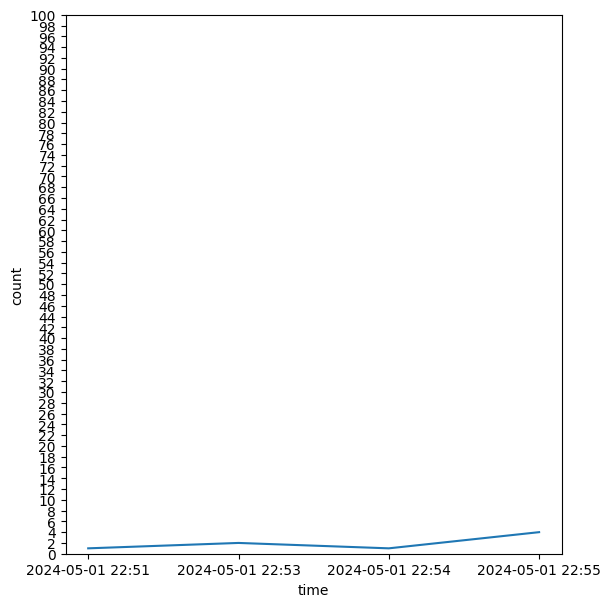

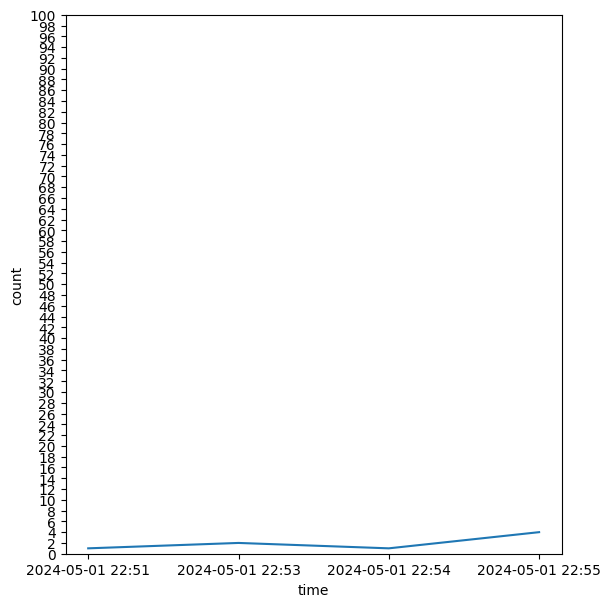

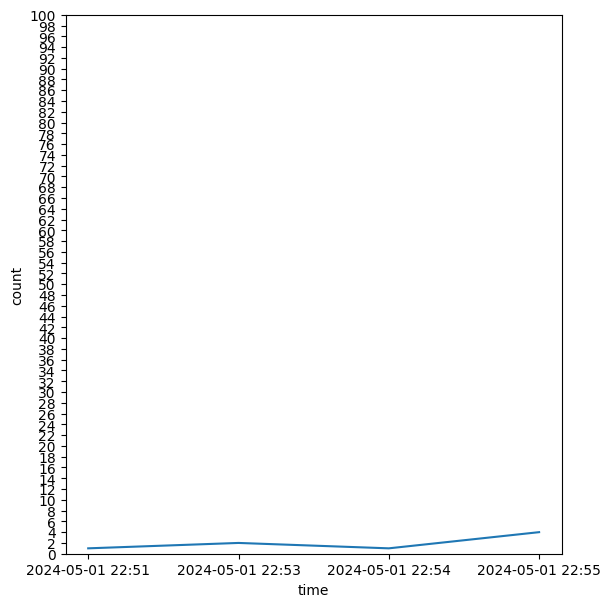

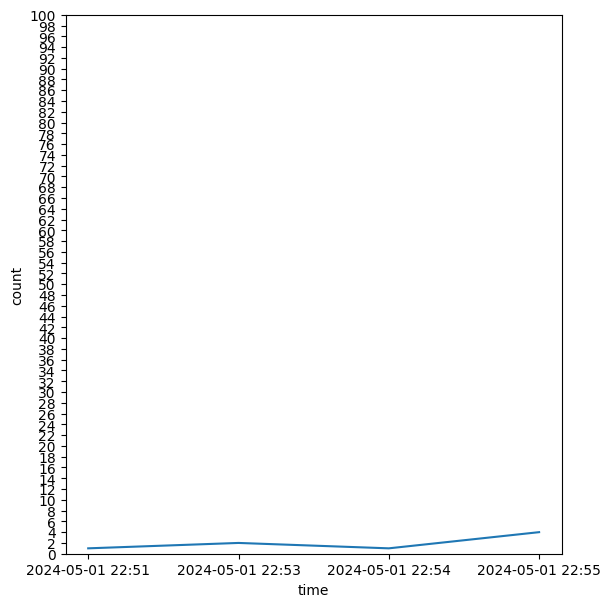

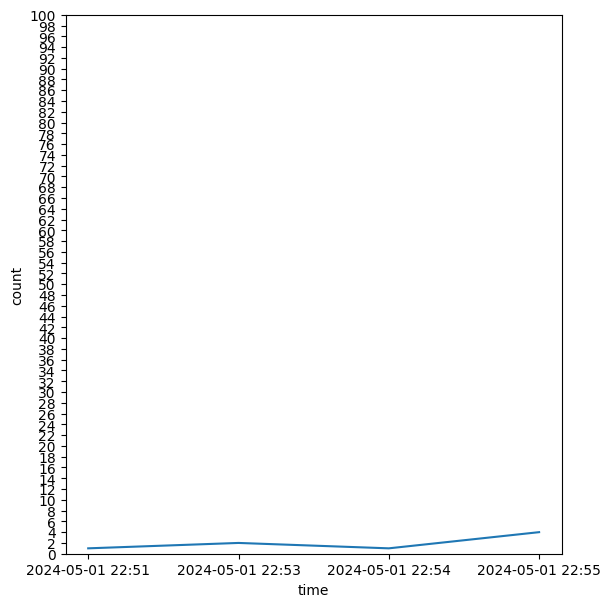

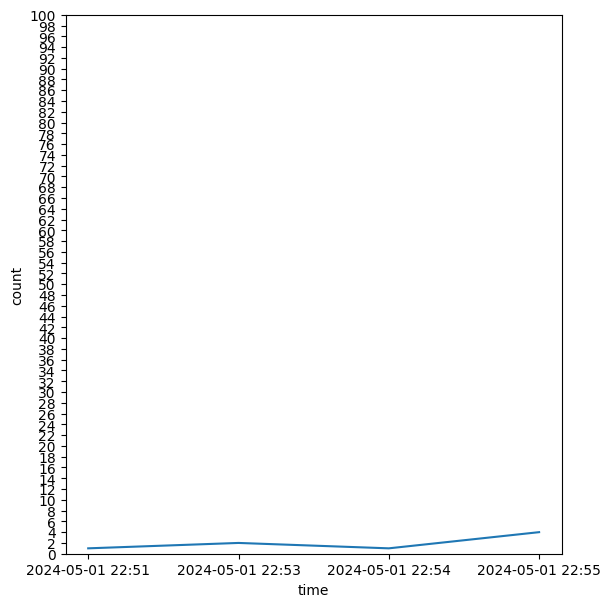

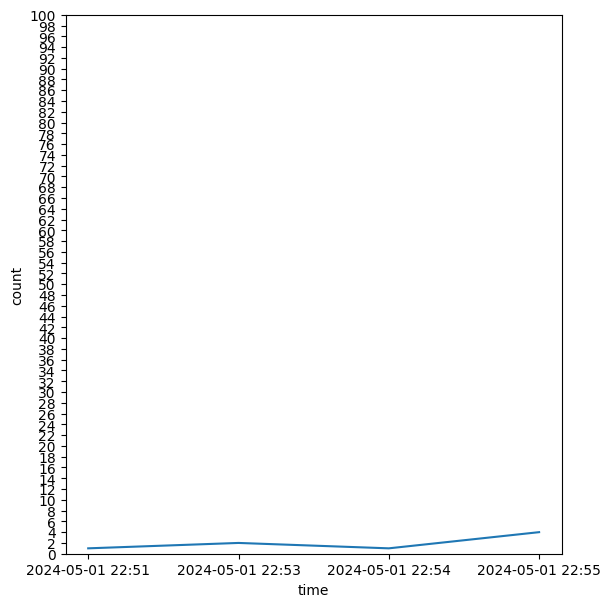

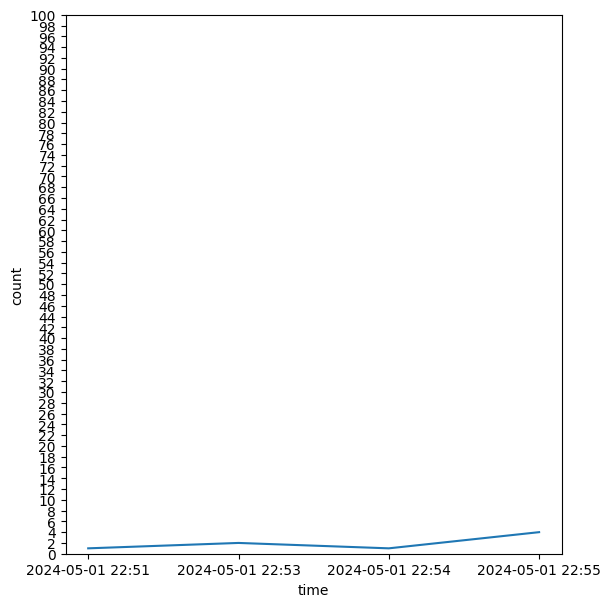

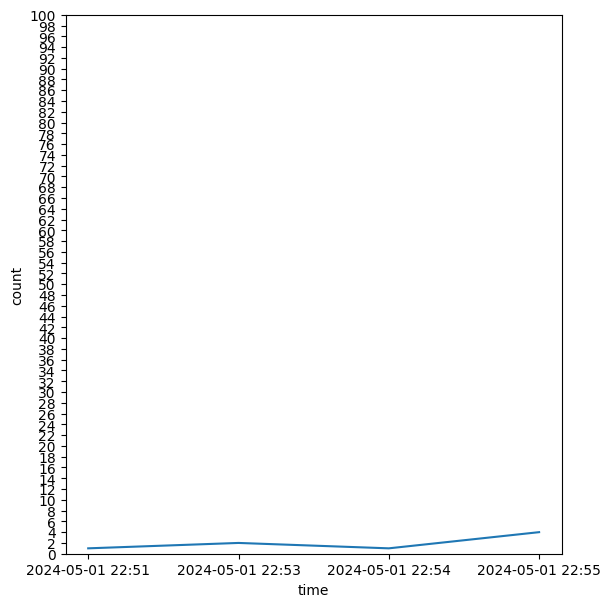

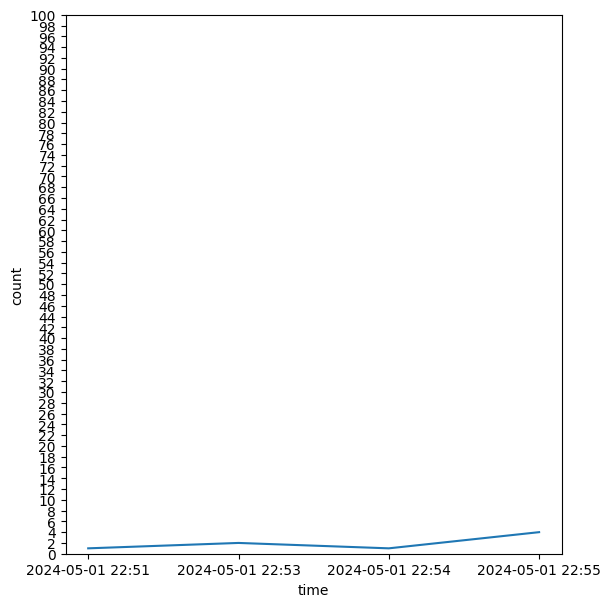

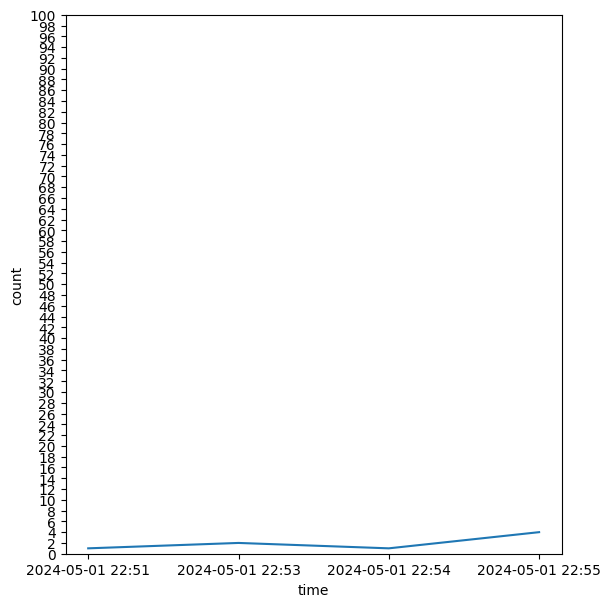

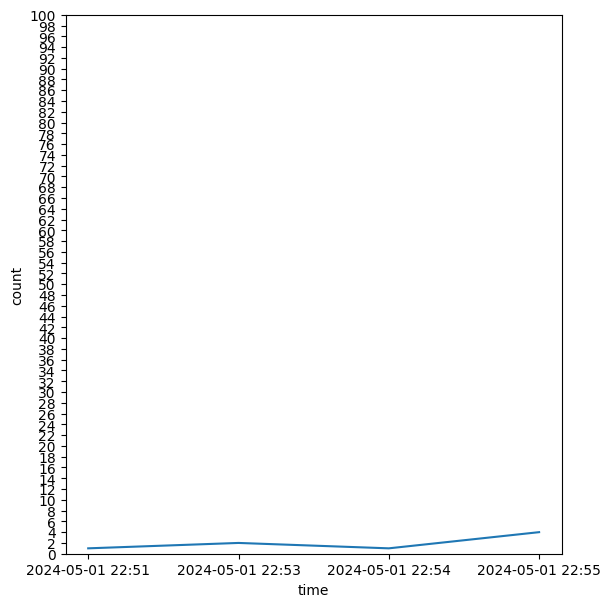

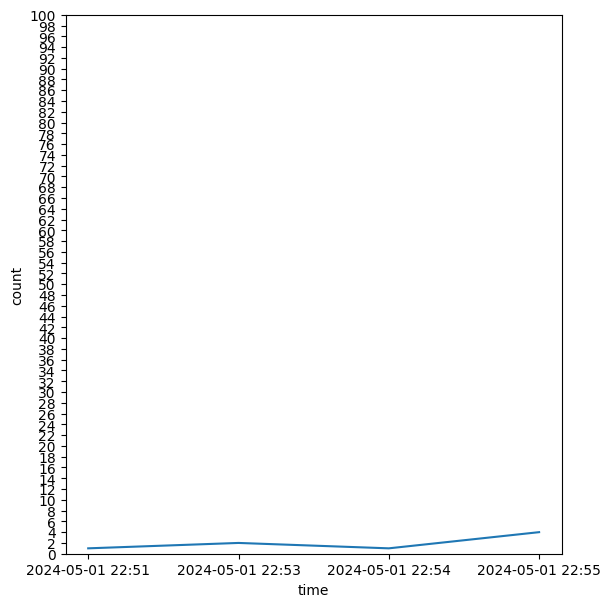

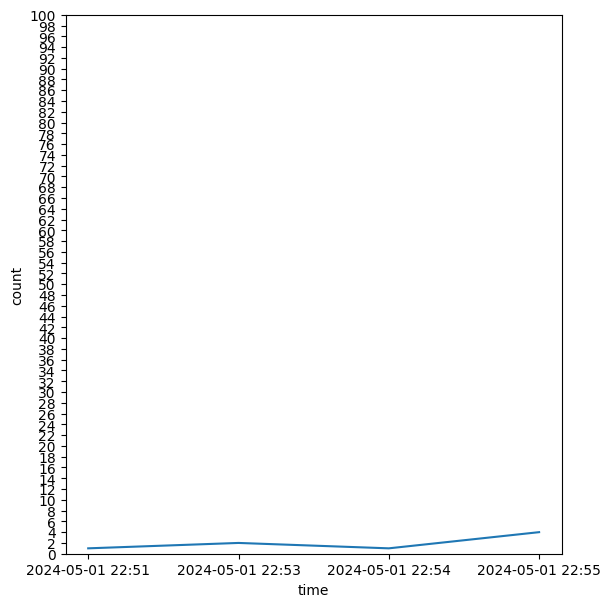

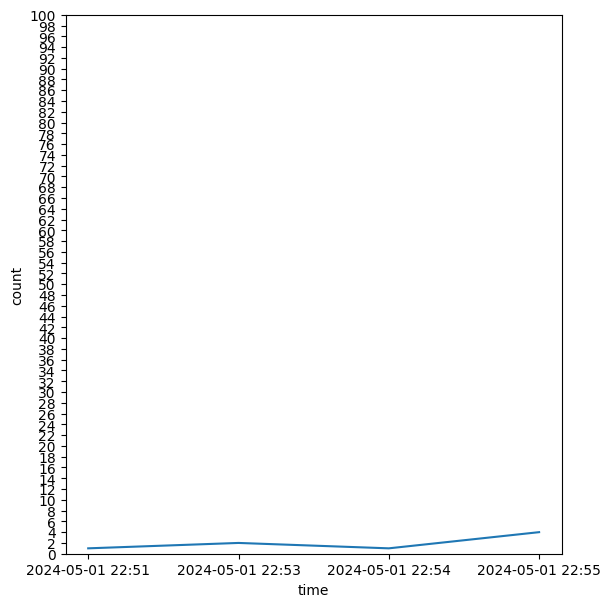

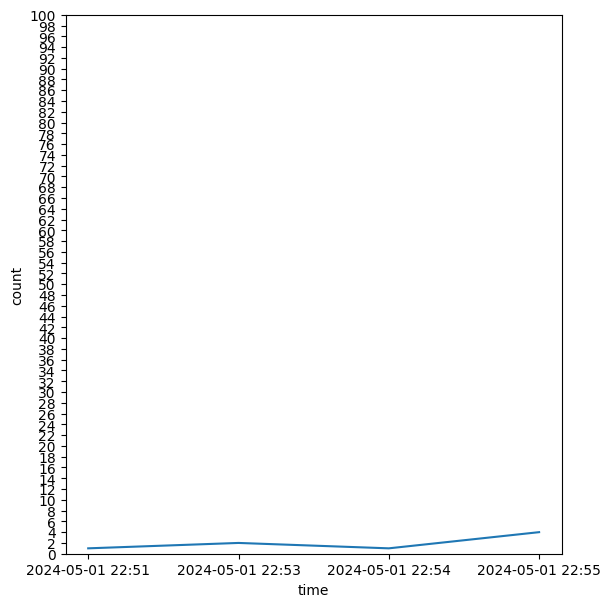

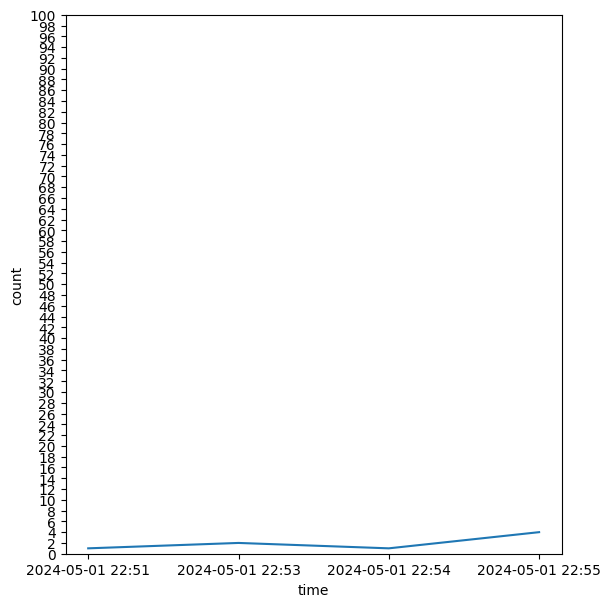

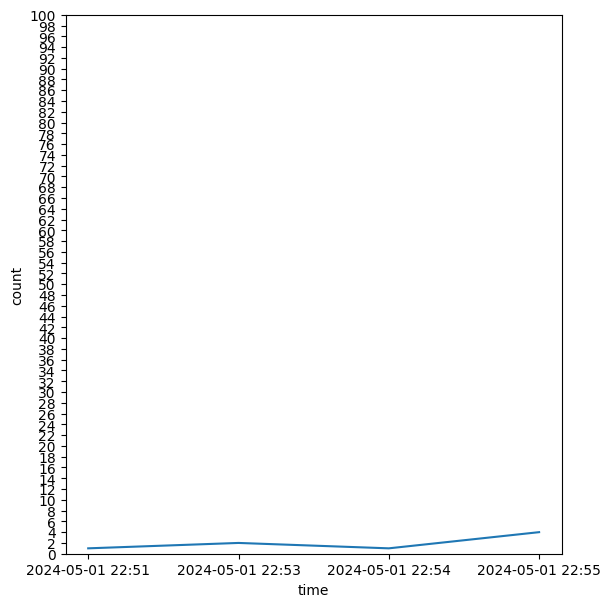

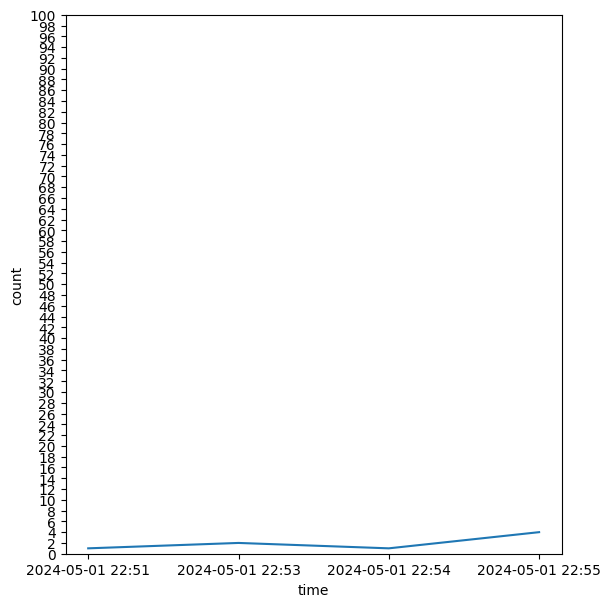

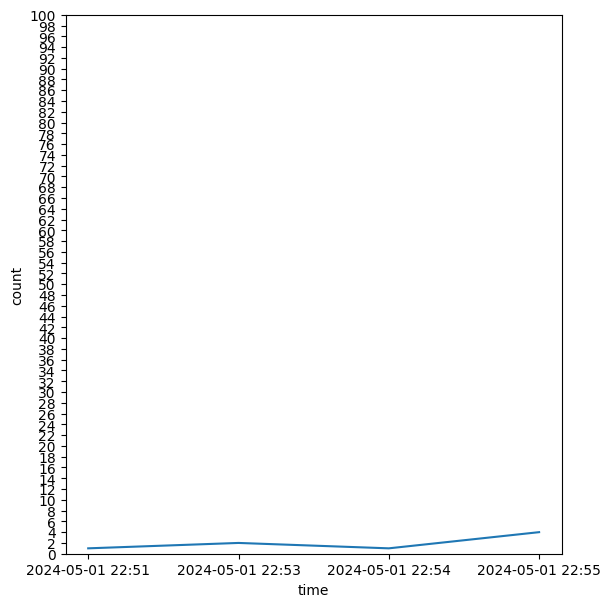

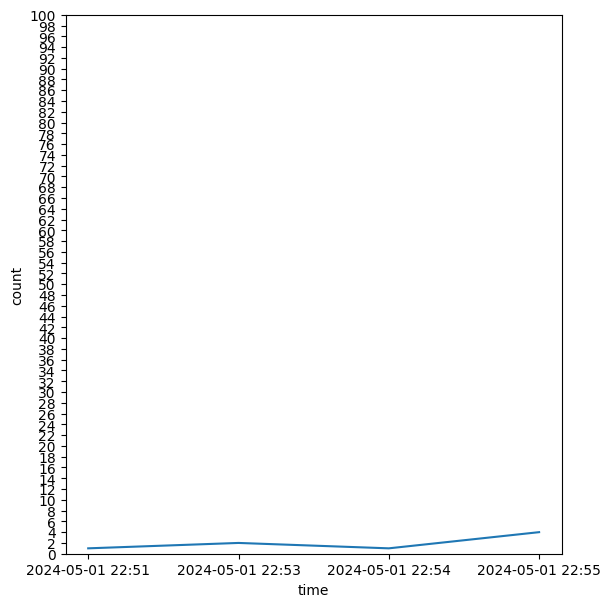

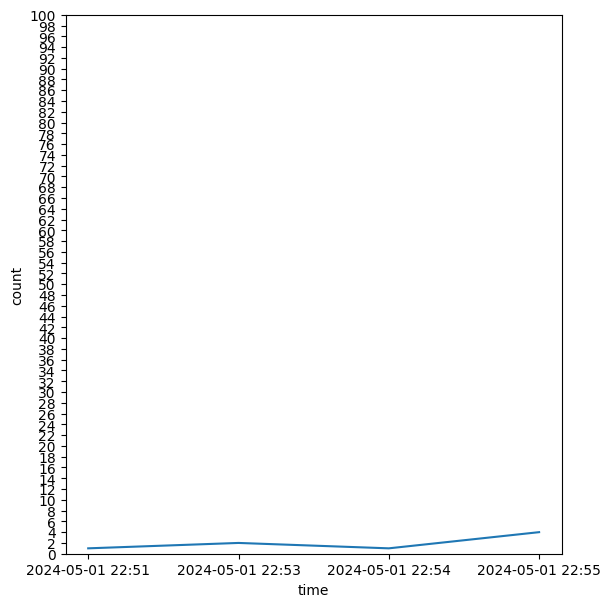

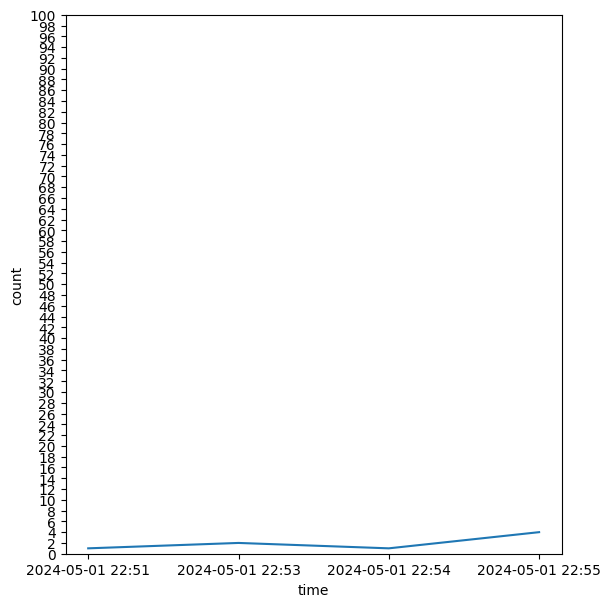

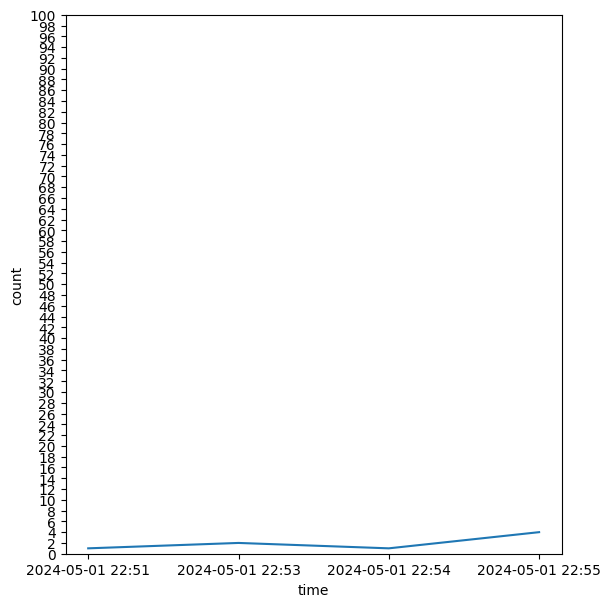

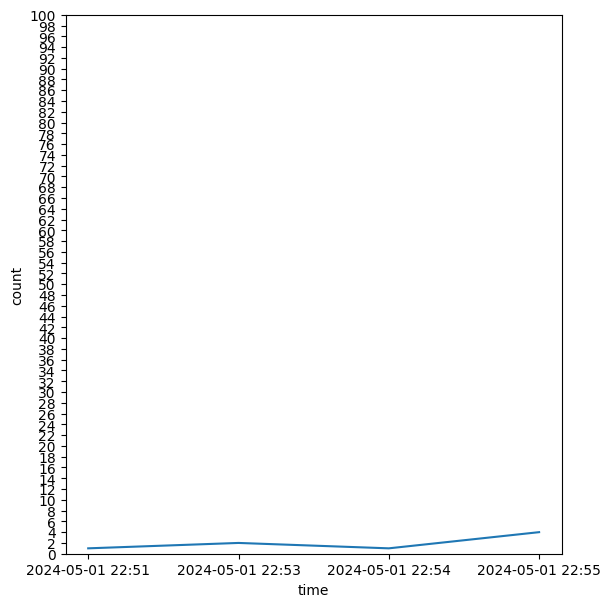

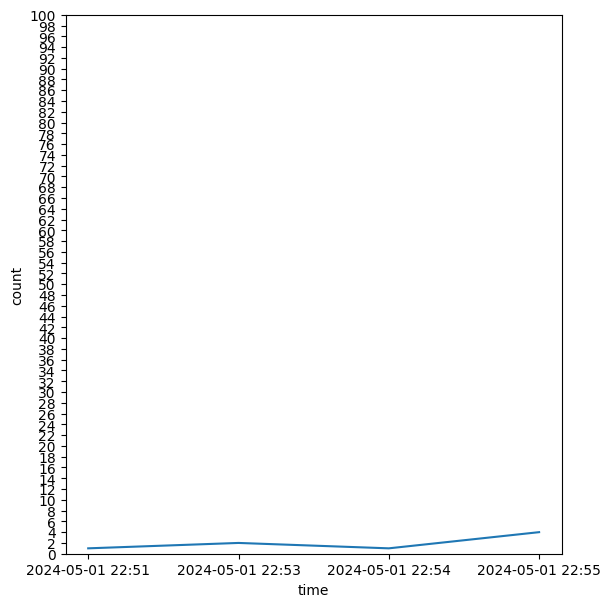

In [8]:
1